In [1]:
import pandas as pd
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_months = 12

In [3]:
basedir = './국토교통부_실거래가_공개시스템/땅값분석/'
yunrip_df = pd.read_csv(basedir + 'yunrip_25.csv')
commerce_df = pd.read_csv(basedir + 'commerce_25.csv')
land_df = pd.read_csv(basedir + 'land.csv')

In [4]:
common_cols = ['시군구', '번지', '용도지역', '도로조건', '계약날짜', '대지면적(㎡)', '거래금액(만원)', '단가(㎡)', '단가(평)', '부동산유형', '건물연식']
common_df = pd.concat([yunrip_df[common_cols], commerce_df[common_cols], land_df[[col for col in land_df.columns if col not in ['지목', '지분구분', '해제사유발생일']]]])
common_df['계약날짜'] = pd.to_datetime(common_df['계약날짜'], format='%Y-%m-%d')
common_df
print(common_df.shape)
common_df.head()

(408768, 11)


,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식
0,서울특별시 강남구 개포동,1264-3,제2종일반주거지역,8m미만,2006-08-29,29.23,11500.0,393.431406,1300.599641,연립다세대,29.0
1,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2006-12-20,56.10,56500.0,1007.130125,3329.355660,연립다세대,33.0
2,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2016-01-16,39.60,23300.0,588.383838,1945.070467,연립다세대,33.0
3,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2016-04-09,39.60,24500.0,618.686869,2045.245770,연립다세대,33.0
4,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2019-10-23,56.10,60000.0,1069.518717,3535.598930,연립다세대,33.0


In [5]:
common_df['용도지역'].value_counts()

제2종일반주거지역    227652
제1종일반주거지역     53207
제3종일반주거지역     48182
제2종일반주거       13006
준주거지역         12306
일반상업지역        11412
준공업지역          9172
제3종일반주거        7810
개발제한구역         7758
일반상업           6348
자연녹지지역         3151
준주거            2716
제1종전용주거지역      2108
준공업            1370
제1종일반주거         808
근린상업지역          579
근린상업            285
제1종전용주거         147
중심상업            143
중심상업지역          139
일반주거지역          110
제2종전용주거지역        90
용도미지정            43
유통상업지역           39
기타               38
전용주거지역           23
자연녹지             22
관리지역             22
일반주거             18
제2종전용주거          13
생산녹지지역            9
유통상업              7
계획관리지역            4
보전녹지지역            2
일반공업지역            1
전용주거              1
생산관리지역            1
일반공업              1
Name: 용도지역, dtype: int64

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 10.89it/s]


(644920, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [10]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_baseline.csv').sort_values(['지번주소', '년']).reset_index(drop=True)
print(land_specs_df.shape)
land_specs_df.head()

(8405705, 10)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,2013.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 100-0,2014.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
2,서울특별시 강남구 개포동 100-0,2015.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
3,서울특별시 강남구 개포동 100-0,2016.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
4,서울특별시 강남구 개포동 100-0,2017.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지


In [11]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '용도지역명2']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(982961, 8)


,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,516.0,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,전,완경사,부정형,맹지


In [12]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [13]:
yunrip_df = yunrip_df[
    (yunrip_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_months)))
]
print(yunrip_df.shape)
yunrip_df.head()

(53820, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
558874,서울특별시 강남구 개포동 170-18,선릉로12길 17,(170-18),54.63,44.19,65000,2,1988.0,32.0,2020-10-16,1189.822442,33.0,연립다세대
558875,서울특별시 강남구 개포동 170-18,선릉로12길 17,(170-18),26.60,21.53,31000,1,1988.0,32.0,2020-12-23,1165.413534,33.0,연립다세대
558877,서울특별시 강남구 개포동 1186-0,논현로8길 24,1186 HOUSE,59.91,39.47,70000,4,2020.0,0.0,2020-08-28,1168.419296,1.0,연립다세대
558878,서울특별시 강남구 개포동 1186-0,논현로8길 24,1186 HOUSE,60.00,39.53,70000,4,2020.0,0.0,2020-09-29,1166.666667,1.0,연립다세대
558879,서울특별시 강남구 개포동 1213-0,개포로32길 6,1213,45.52,25.79,59000,3,2016.0,4.0,2020-08-18,1296.133568,5.0,연립다세대


In [14]:
yunrip_df = yunrip_df[
    (yunrip_df['건물연식'] <= 1)
]
print(yunrip_df.shape)
yunrip_df.head()

(9403, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
558877,서울특별시 강남구 개포동 1186-0,논현로8길 24,1186 HOUSE,59.91,39.47,70000,4,2020.0,0.0,2020-08-28,1168.419296,1.0,연립다세대
558878,서울특별시 강남구 개포동 1186-0,논현로8길 24,1186 HOUSE,60.00,39.53,70000,4,2020.0,0.0,2020-09-29,1166.666667,1.0,연립다세대
559157,서울특별시 강남구 논현동 160-4,강남대로122길 29-6,논현퍼스티움,28.22,16.93,46300,3,2020.0,0.0,2020-08-31,1640.680369,1.0,연립다세대
559206,서울특별시 강남구 논현동 177-10,논현로117길 22,모두가행복한집 A,25.78,17.50,34000,3,2020.0,0.0,2020-10-06,1318.851823,1.0,연립다세대
559585,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.27,17.21,52650,5,2020.0,0.0,2020-10-08,1798.770072,1.0,연립다세대


In [15]:
common_df = common_df[
    (common_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_months)))
]

In [16]:
print(common_df.shape)
common_df.head()

(25670, 11)


,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식
30,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-14,18.30,24700.0,1349.726776,4461.906530,연립다세대,28.0
31,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-25,19.33,24000.0,1241.593378,4104.440766,연립다세대,28.0
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0
59,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2020-11-10,21.09,31000.0,1469.890944,4859.143433,연립다세대,29.0


In [17]:
yunrip_df = yunrip_df.dropna(subset=['지번주소']).reset_index(drop=True)
print(yunrip_df.shape)

(9403, 13)


In [18]:
yunrip_df = yunrip_df[
    (yunrip_df['전용면적(㎡)'] <= 32)
    &(yunrip_df['전용면적(㎡)'] >= 28)
]
print(yunrip_df.shape)
yunrip_df.head()

(2752, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
2,서울특별시 강남구 논현동 160-4,강남대로122길 29-6,논현퍼스티움,28.22,16.93,46300,3,2020.0,0.0,2020-08-31,1640.680369,1.0,연립다세대
4,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.27,17.21,52650,5,2020.0,0.0,2020-10-08,1798.770072,1.0,연립다세대
5,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.64,17.41,54350,5,2020.0,0.0,2020-10-08,1833.670715,1.0,연립다세대
6,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.64,17.41,54850,6,2020.0,0.0,2020-10-08,1850.539811,1.0,연립다세대
7,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.64,17.41,53850,2,2020.0,0.0,2020-10-08,1816.801619,1.0,연립다세대


In [19]:
yunrip_df['구'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_df['동'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [20]:
yunrip_merge_df = yunrip_df.merge(last_df, on=['지번주소'])
print(yunrip_merge_df.shape)
yunrip_merge_df.head()

(2724, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 논현동 160-4,강남대로122길 29-6,논현퍼스티움,28.22,16.93,46300,3,2020.0,0.0,2020-08-31,1640.680369,1.0,연립다세대,강남구,논현동,대,575.1,제2종일반주거지역,연립,평지,세로장방,세로한면(가)
1,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.27,17.21,52650,5,2020.0,0.0,2020-10-08,1798.770072,1.0,연립다세대,강남구,역삼동,대,525.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)
2,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.64,17.41,54350,5,2020.0,0.0,2020-10-08,1833.670715,1.0,연립다세대,강남구,역삼동,대,525.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)
3,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.64,17.41,54850,6,2020.0,0.0,2020-10-08,1850.539811,1.0,연립다세대,강남구,역삼동,대,525.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)
4,서울특별시 강남구 역삼동 778-15,언주로69길 23-4,NTRAUM YEOKSAM,29.64,17.41,53850,2,2020.0,0.0,2020-10-08,1816.801619,1.0,연립다세대,강남구,역삼동,대,525.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)


In [21]:
yunrip_merge_df['구'].nunique()

25

In [22]:
common_df.head()

,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식
30,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-14,18.30,24700.0,1349.726776,4461.906530,연립다세대,28.0
31,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-25,19.33,24000.0,1241.593378,4104.440766,연립다세대,28.0
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0
59,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2020-11-10,21.09,31000.0,1469.890944,4859.143433,연립다세대,29.0


In [23]:
common_df['구'] = common_df['시군구'].apply(lambda x: x.split(' ')[1])
common_df['동'] = common_df['시군구'].apply(lambda x: x.split(' ')[2])
common_df.head()

,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식,구,동
30,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-14,18.30,24700.0,1349.726776,4461.906530,연립다세대,28.0,강남구,개포동
31,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-25,19.33,24000.0,1241.593378,4104.440766,연립다세대,28.0,강남구,개포동
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0,강남구,개포동
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0,강남구,개포동
59,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2020-11-10,21.09,31000.0,1469.890944,4859.143433,연립다세대,29.0,강남구,개포동


In [24]:
common_df = common_df.rename(columns={'단가(㎡)':'단가(만원/㎡)'})
common_df.head()

,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(만원/㎡),단가(평),부동산유형,건물연식,구,동
30,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-14,18.30,24700.0,1349.726776,4461.906530,연립다세대,28.0,강남구,개포동
31,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-01-25,19.33,24000.0,1241.593378,4104.440766,연립다세대,28.0,강남구,개포동
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0,강남구,개포동
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0,강남구,개포동
59,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2020-11-10,21.09,31000.0,1469.890944,4859.143433,연립다세대,29.0,강남구,개포동


In [25]:
last_df.head()

,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,516.0,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,전,완경사,부정형,맹지


In [26]:
last_df['구'] = last_df['지번주소'].apply(lambda x: x.split(' ')[1])
last_df['동'] = last_df['지번주소'].apply(lambda x: x.split(' ')[2])
last_df.head()

,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,구,동
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,전,완경사,부정형,맹지,강남구,개포동
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,전,평지,부정형,맹지,강남구,개포동
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,전,평지,부정형,맹지,강남구,개포동
3,서울특별시 강남구 개포동 103-0,전,516.0,개발제한구역,전,평지,부정형,맹지,강남구,개포동
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,전,완경사,부정형,맹지,강남구,개포동


강남구
제2종일반주거지역    0.387454
제3종일반주거지역    0.248594
개발제한구역       0.092888
일반상업지역       0.082050
제1종일반주거지역    0.074393
자연녹지지역       0.049242
제1종전용주거지역    0.048417
준주거지역        0.011339
생산녹지지역       0.005625
Name: 용도지역명1, dtype: float64


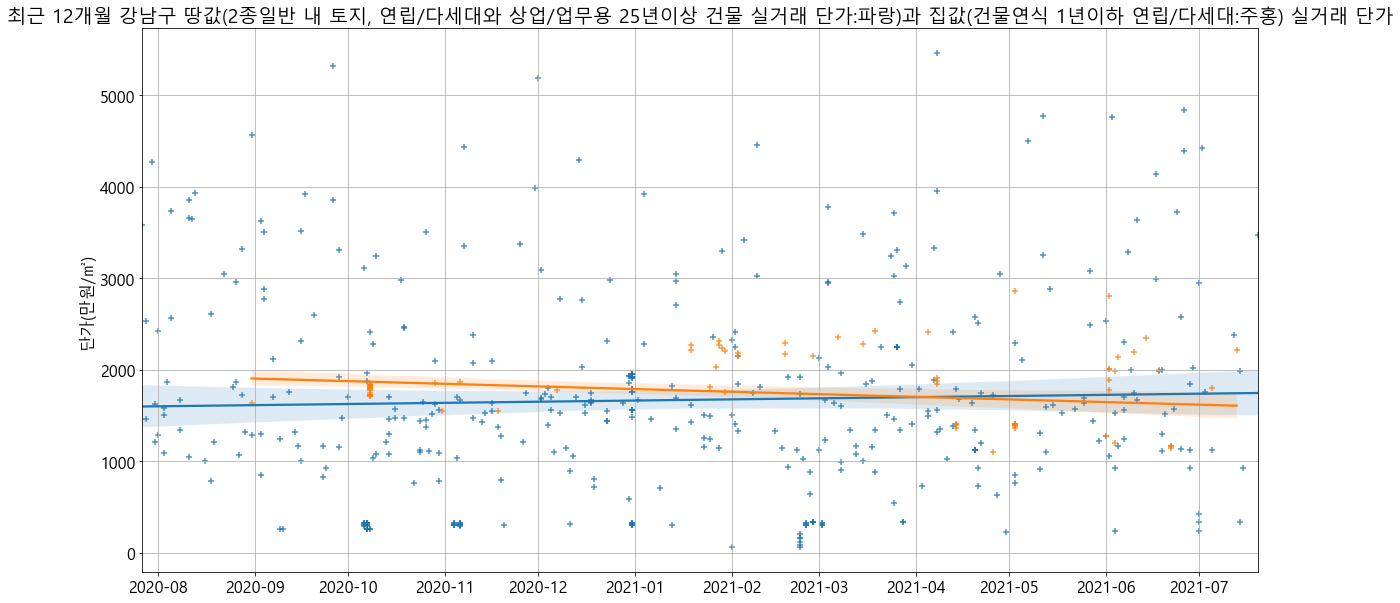

<Figure size 432x288 with 0 Axes>

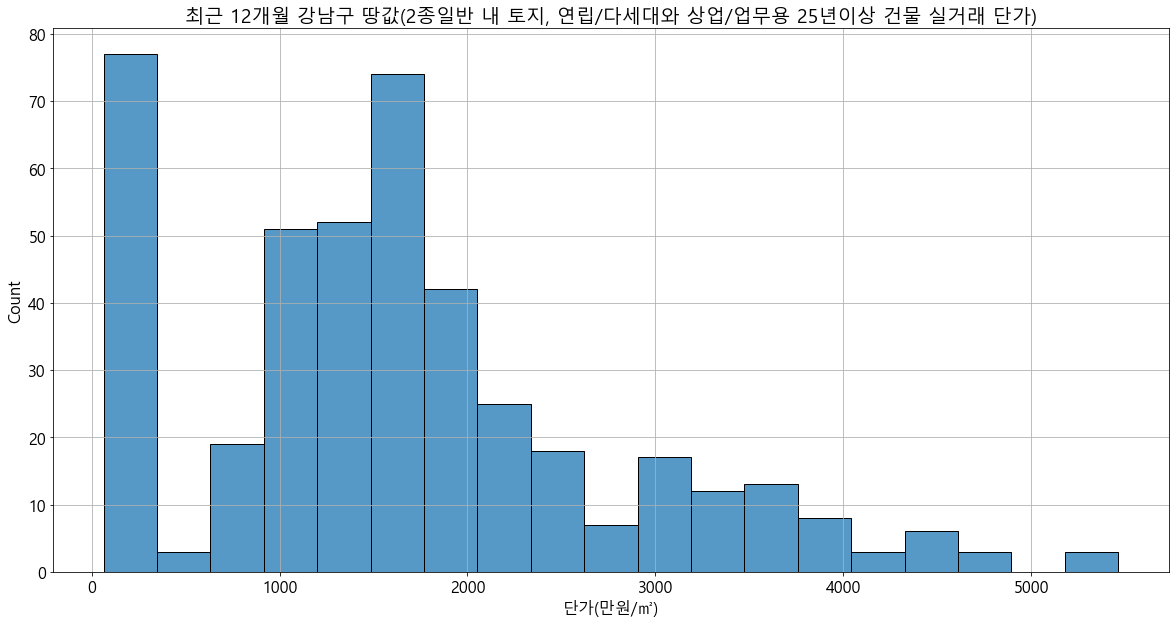

<Figure size 432x288 with 0 Axes>

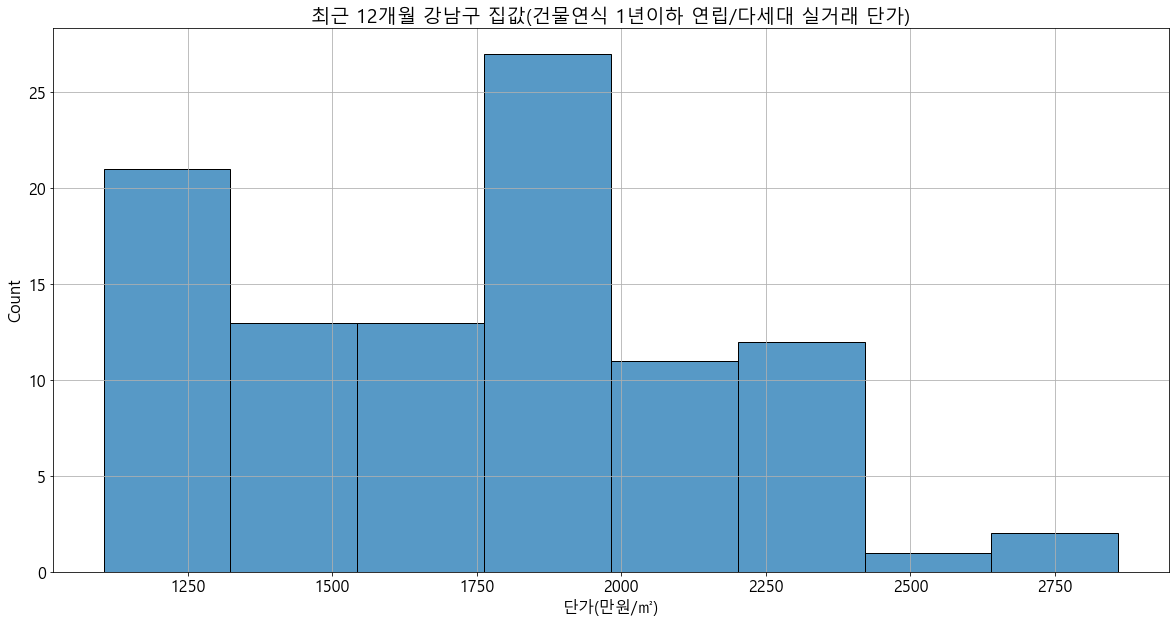

count     100.000000
mean     1740.866742
std       389.443959
min      1104.417671
25%      1398.373875
50%      1783.701010
75%      1987.962021
max      2859.526193
Name: 단가(만원/㎡), dtype: float64
count     433.000000
mean     1670.416273
std      1086.197683
min        63.348416
25%      1003.366559
50%      1553.398058
75%      2128.688921
max      5464.480874
Name: 단가(만원/㎡), dtype: float64
강동구
제2종일반주거지역    0.566183
개발제한구역       0.151090
제3종일반주거지역    0.143143
일반상업지역       0.051402
준주거지역        0.036430
자연녹지지역       0.031471
제1종일반주거지역    0.009982
근린상업지역       0.005690
제1종전용주거지역    0.004609
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

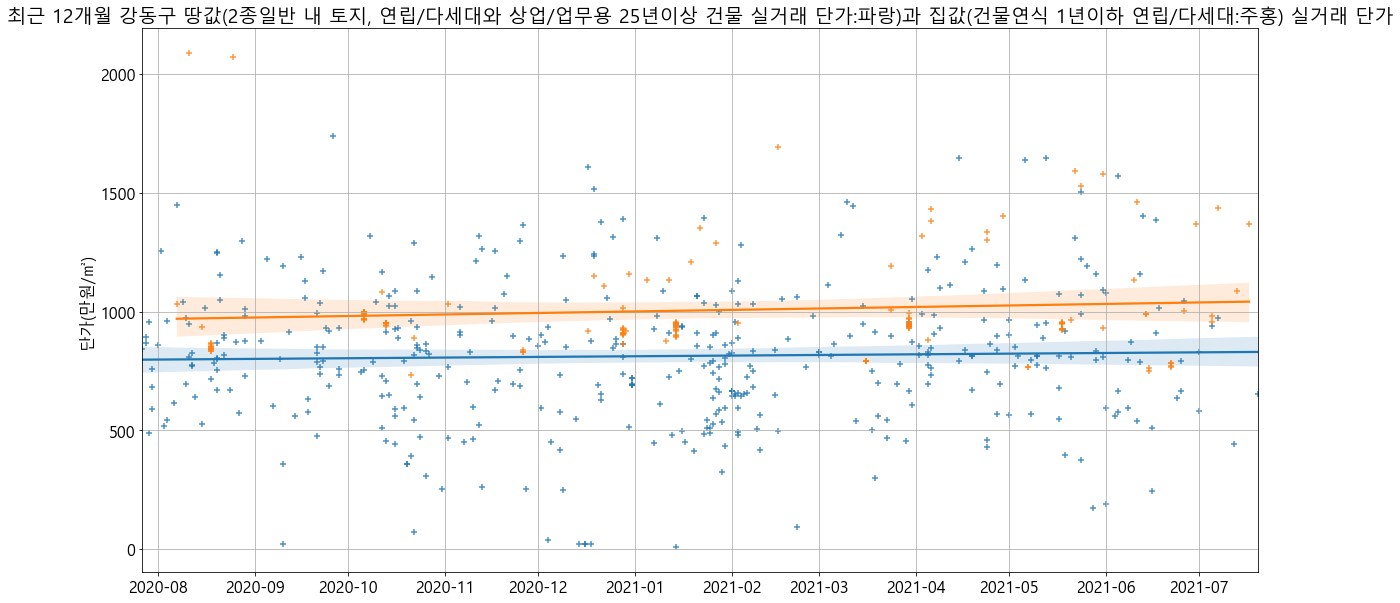

<Figure size 432x288 with 0 Axes>

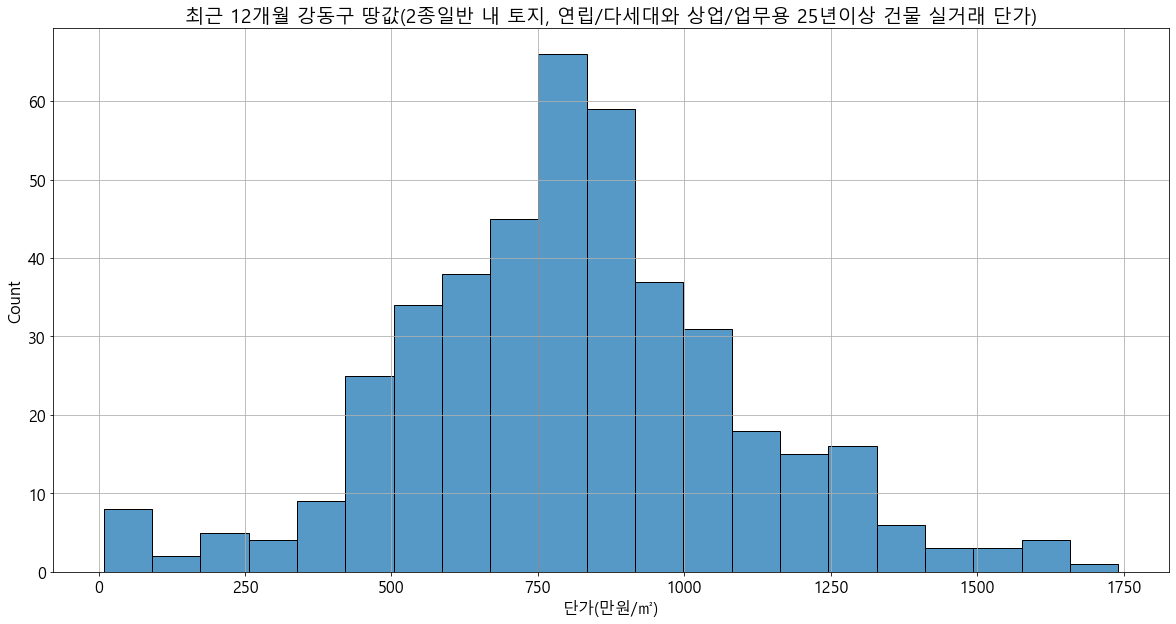

<Figure size 432x288 with 0 Axes>

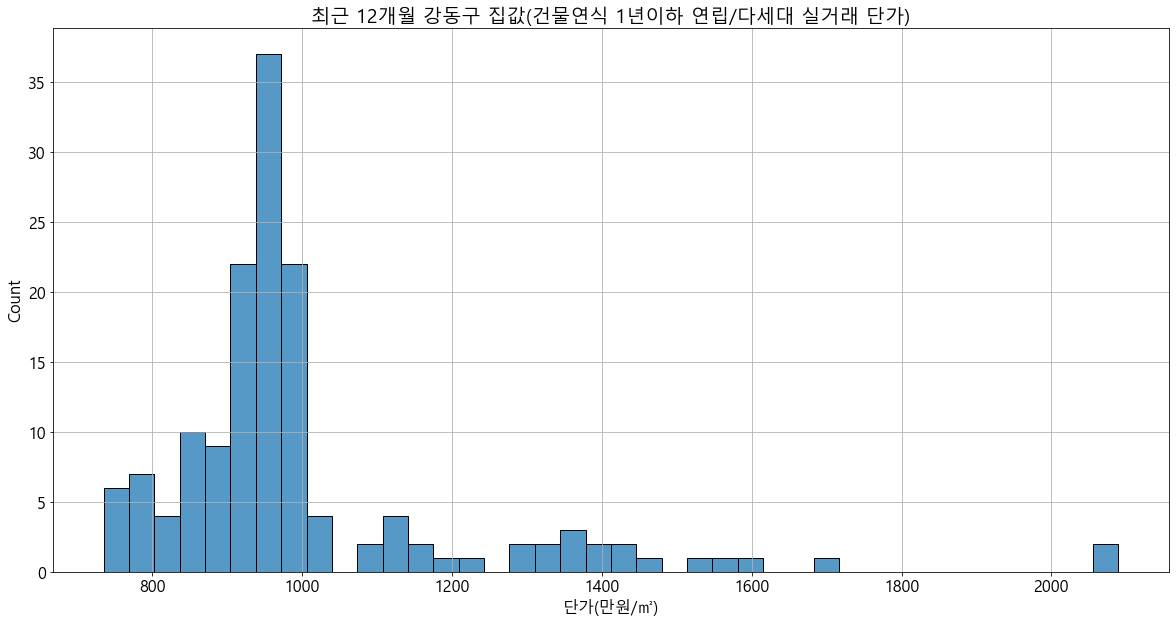

count     149.000000
mean     1005.416123
std       217.165259
min       734.996628
25%       908.636212
50%       949.748744
75%       999.298738
max      2089.235127
Name: 단가(만원/㎡), dtype: float64
count     429.000000
mean      812.725099
std       290.173752
min         8.620690
25%       646.123260
50%       811.462239
75%       964.611872
max      1740.976645
Name: 단가(만원/㎡), dtype: float64
강북구
제2종일반주거지역    0.665558
제3종일반주거지역    0.138331
제1종일반주거지역    0.104683
준주거지역        0.045033
개발제한구역       0.023163
일반상업지역       0.019122
자연녹지지역       0.004111
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

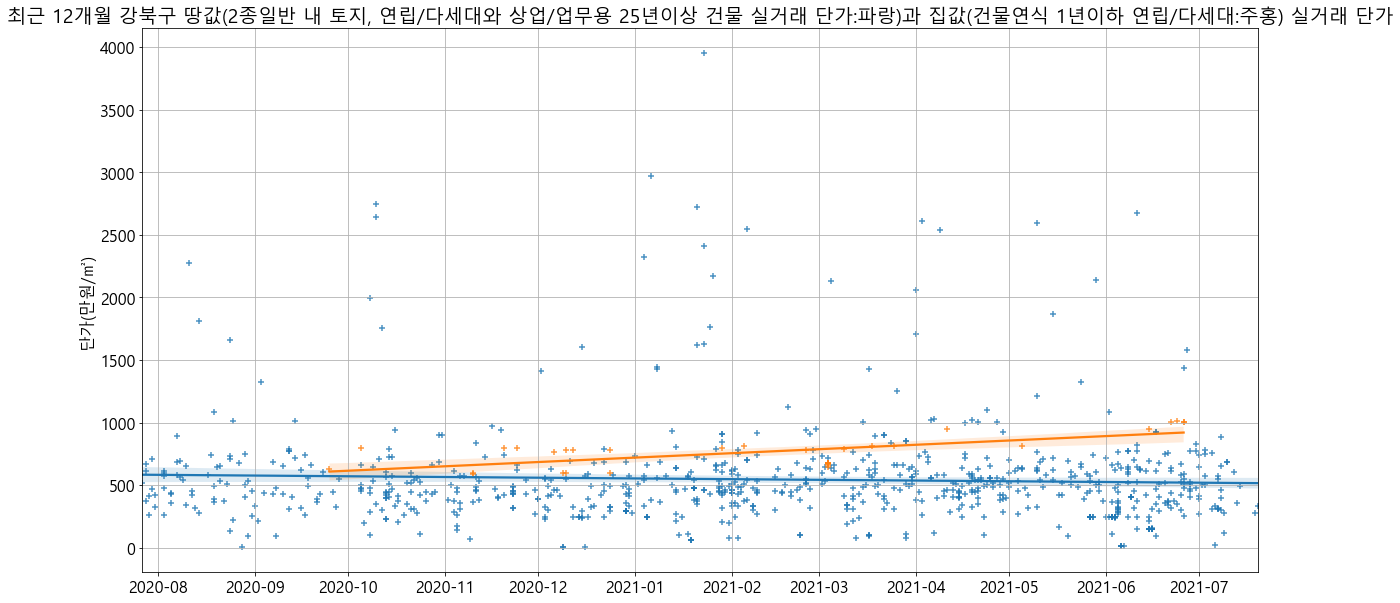

<Figure size 432x288 with 0 Axes>

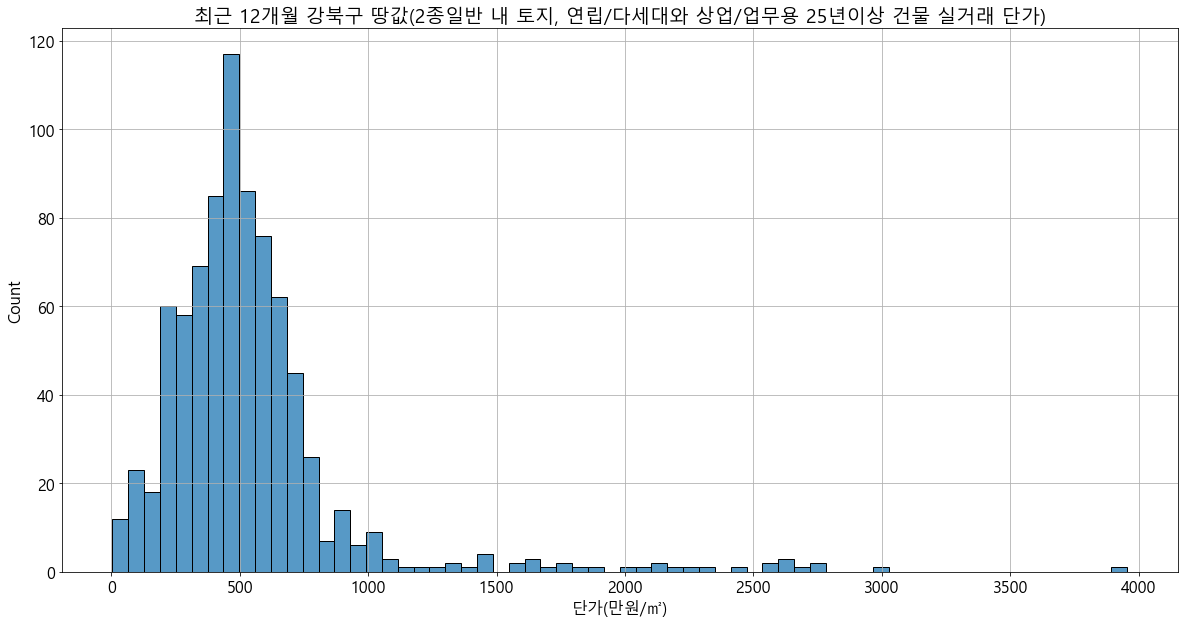

<Figure size 432x288 with 0 Axes>

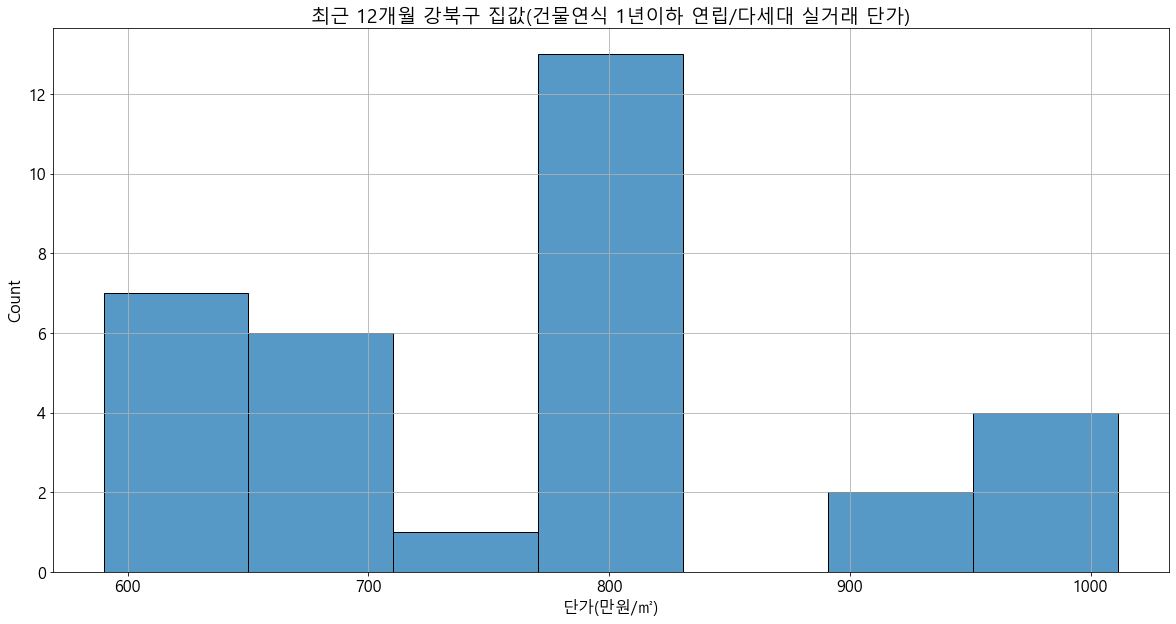

count      33.000000
mean      766.784012
std       129.941793
min       589.915966
25%       665.303555
50%       784.117451
75%       809.574094
max      1011.463250
Name: 단가(만원/㎡), dtype: float64
count     814.000000
mean      544.779342
std       398.942645
min         4.347826
25%       337.316113
50%       476.906146
75%       626.639207
max      3954.802260
Name: 단가(만원/㎡), dtype: float64
강서구
제2종일반주거지역    0.492100
개발제한구역       0.167655
제3종일반주거지역    0.117451
준공업지역        0.048529
제1종일반주거지역    0.045903
자연녹지지역       0.043594
일반상업지역       0.034473
제1종전용주거지역    0.018221
준주거지역        0.014305
근린상업지역       0.014215
생산녹지지역       0.003124
유통상업지역       0.000430
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

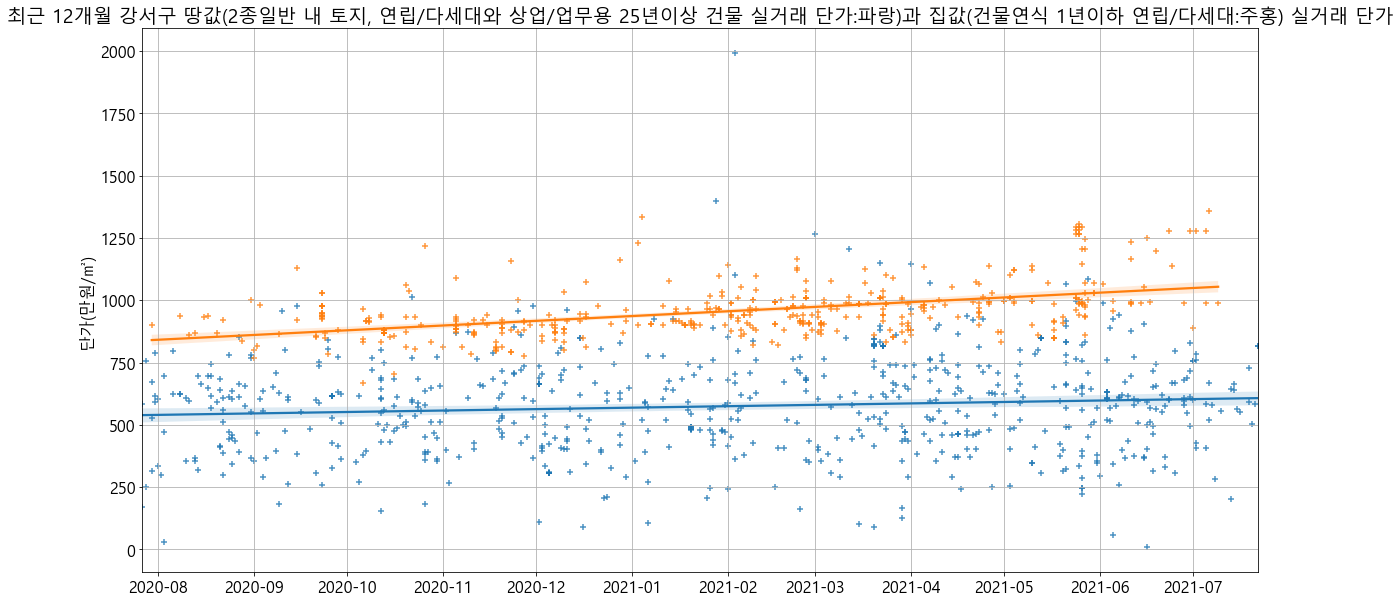

<Figure size 432x288 with 0 Axes>

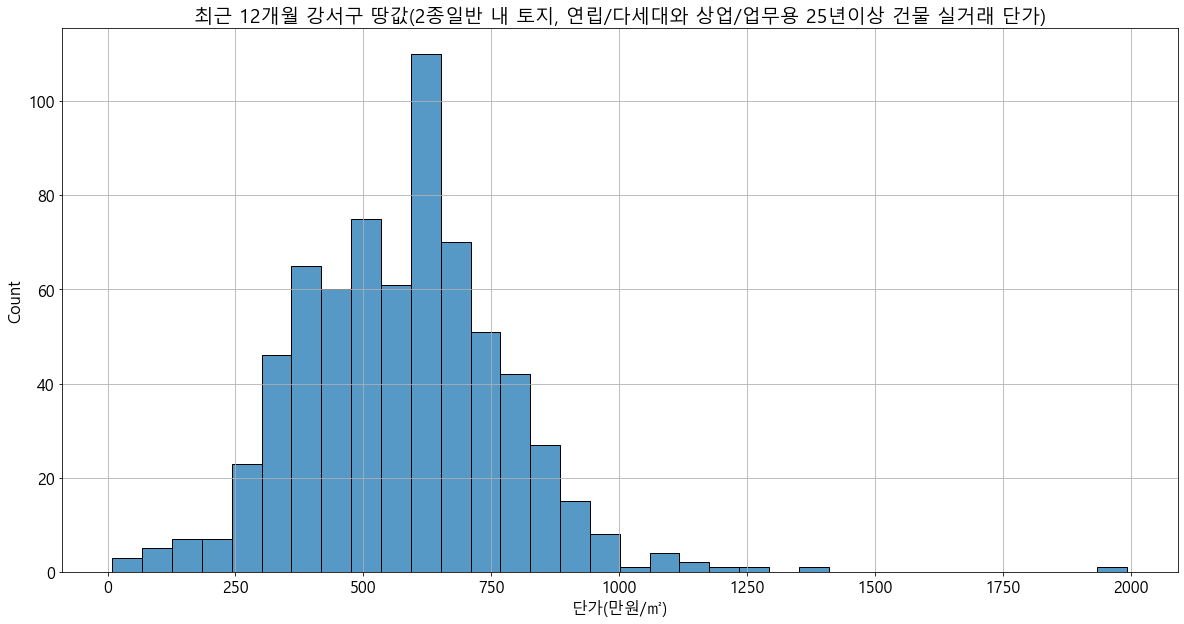

<Figure size 432x288 with 0 Axes>

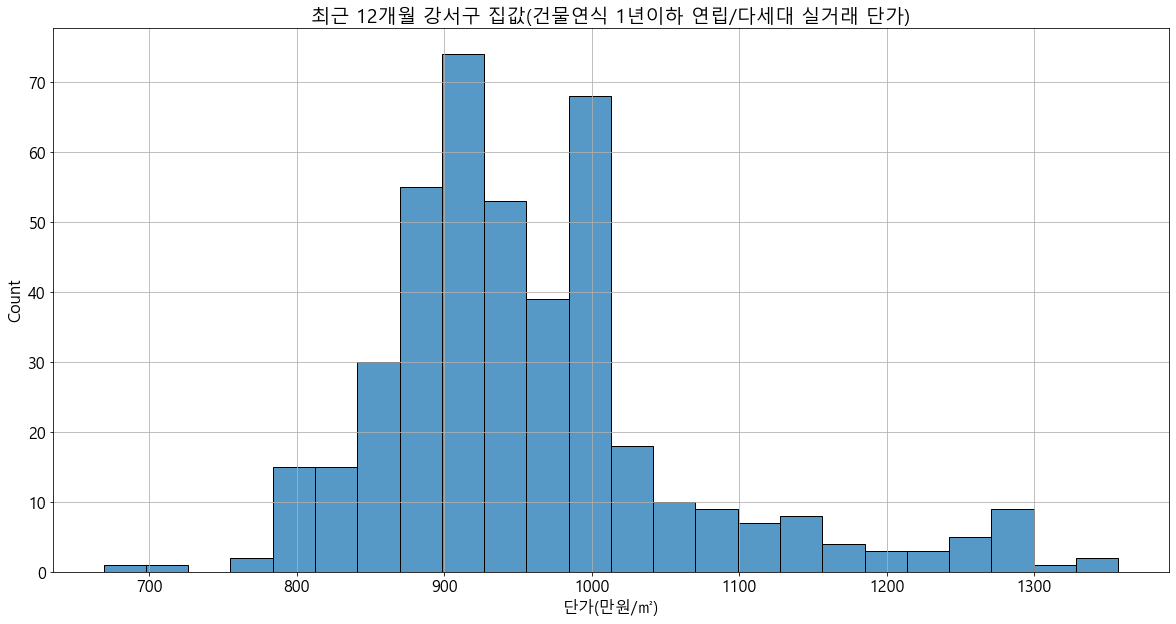

count     432.000000
mean      957.356929
std       107.427021
min       669.014085
25%       885.695187
50%       936.425305
75%       996.895481
max      1356.783920
Name: 단가(만원/㎡), dtype: float64
count     686.000000
mean      575.080193
std       200.703496
min         9.562842
25%       435.413431
50%       585.735758
75%       695.320474
max      1992.592593
Name: 단가(만원/㎡), dtype: float64
관악구
제2종일반주거지역    0.605000
제1종일반주거지역    0.149492
제3종일반주거지역    0.133656
준주거지역        0.062320
일반상업지역       0.028943
자연녹지지역       0.017434
개발제한구역       0.003154
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

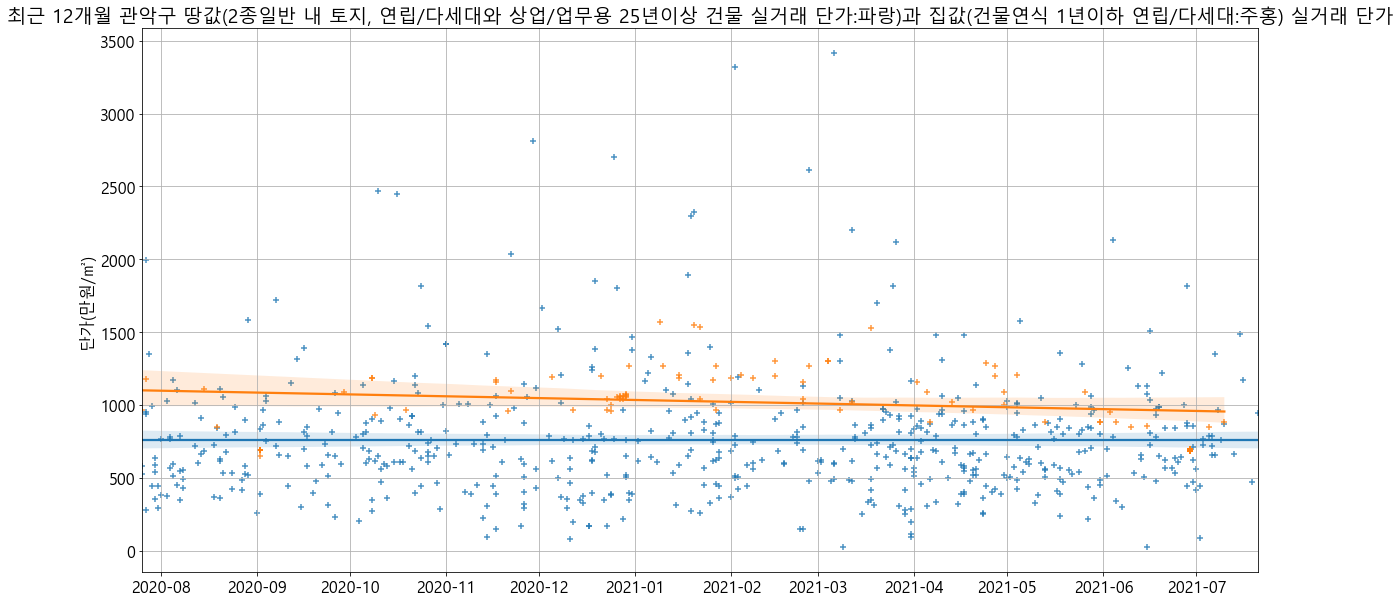

<Figure size 432x288 with 0 Axes>

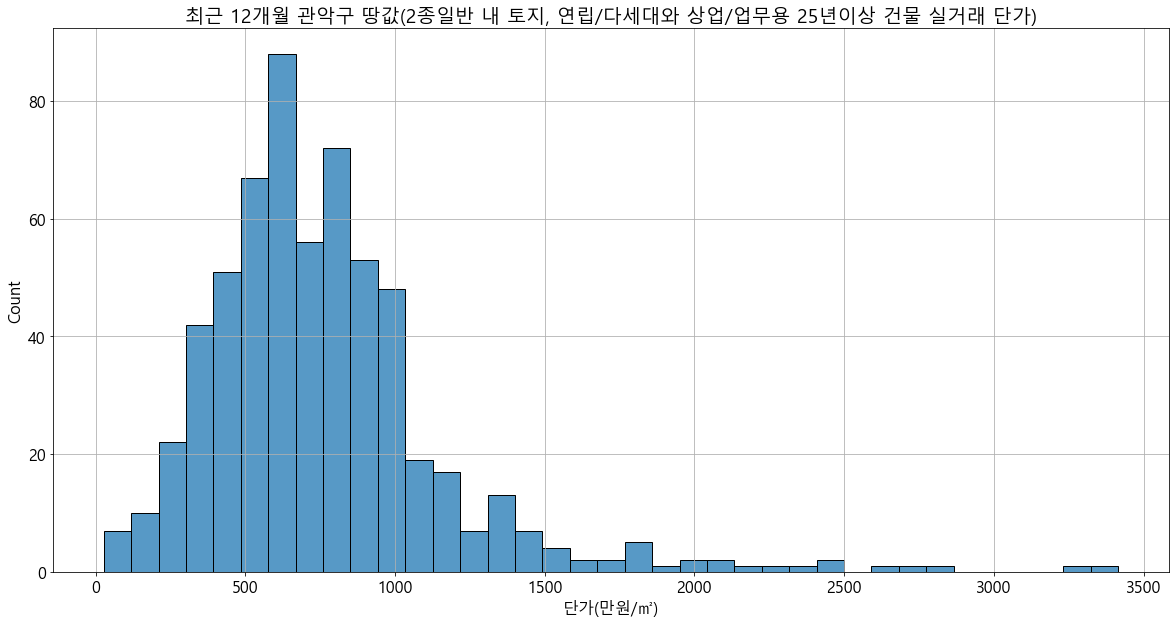

<Figure size 432x288 with 0 Axes>

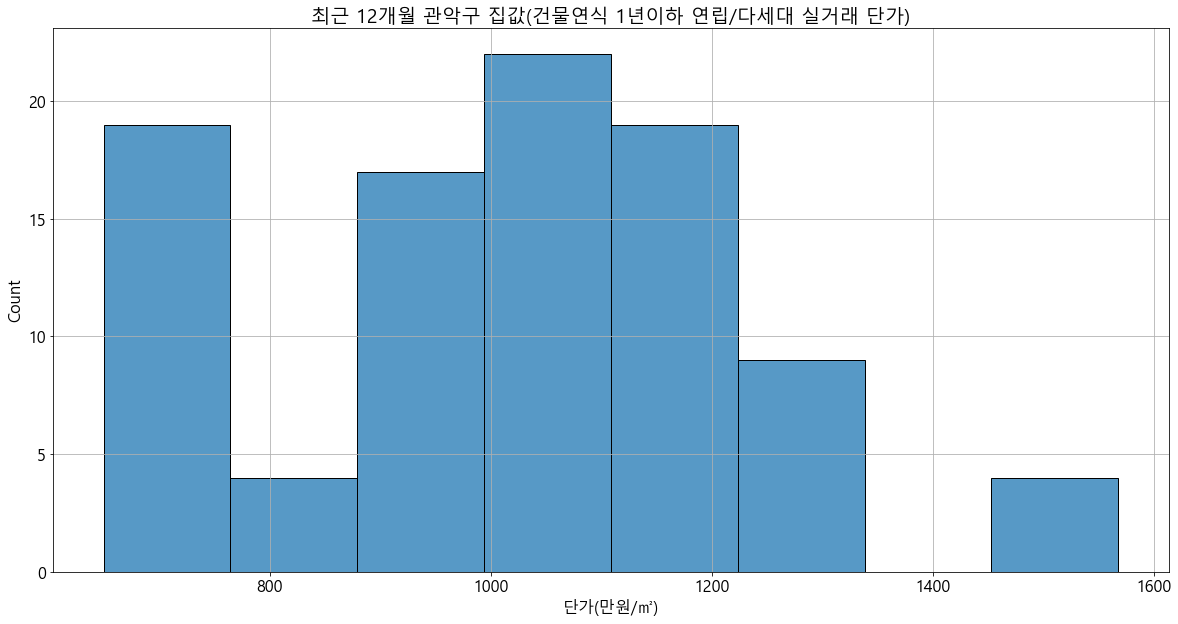

count      94.000000
mean     1019.776647
std       222.157428
min       649.556401
25%       882.383834
50%      1044.328476
75%      1185.461957
max      1567.711808
Name: 단가(만원/㎡), dtype: float64
count     607.000000
mean      763.578464
std       416.087511
min        27.253669
25%       515.557054
50%       689.013035
75%       909.274521
max      3415.559772
Name: 단가(만원/㎡), dtype: float64
광진구
제2종일반주거지역    0.609132
제3종일반주거지역    0.149905
제1종일반주거지역    0.143574
준주거지역        0.054354
일반상업지역       0.018293
자연녹지지역       0.018293
개발제한구역       0.005602
제1종전용주거지역    0.000846
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

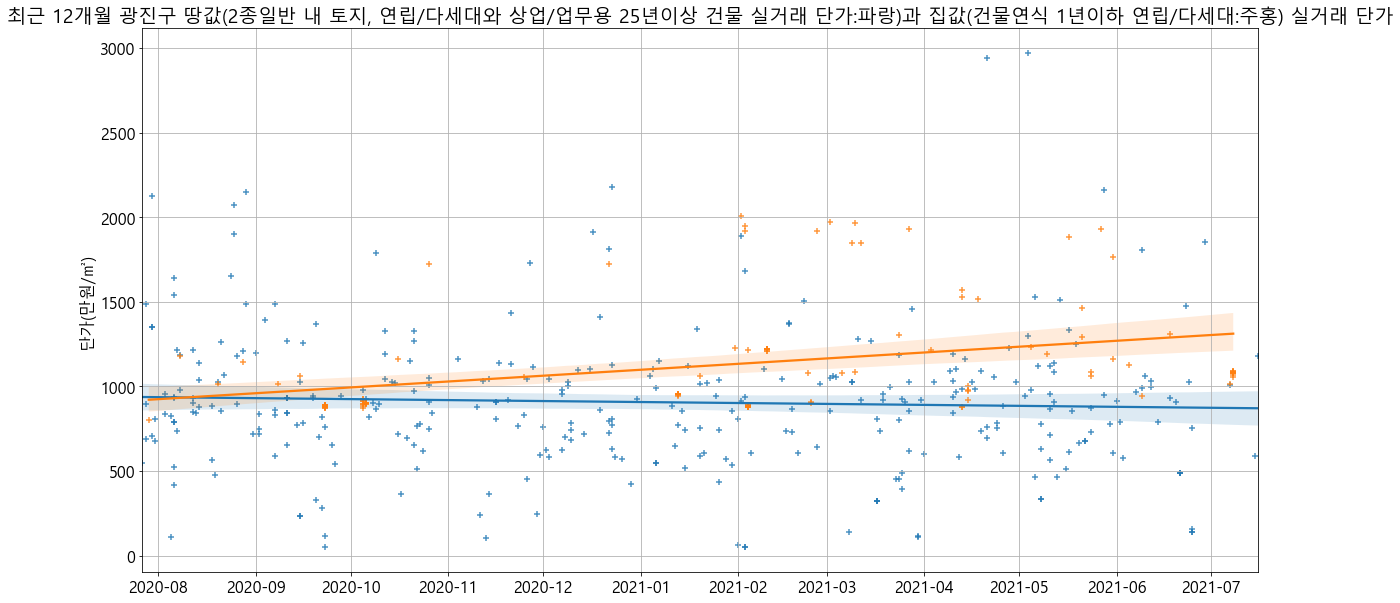

<Figure size 432x288 with 0 Axes>

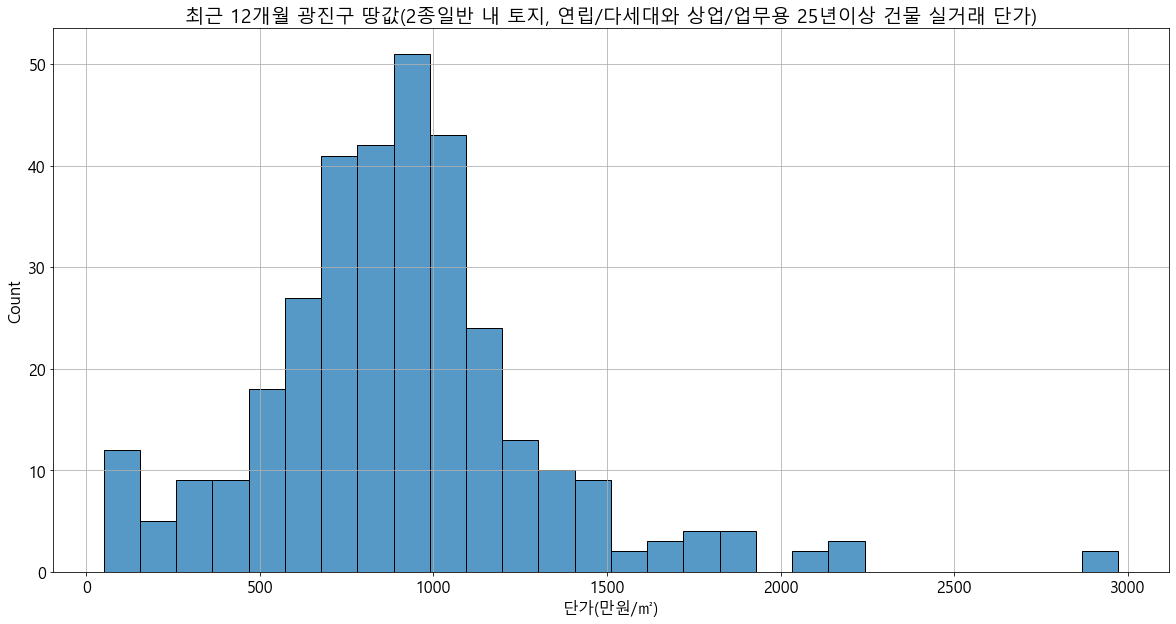

<Figure size 432x288 with 0 Axes>

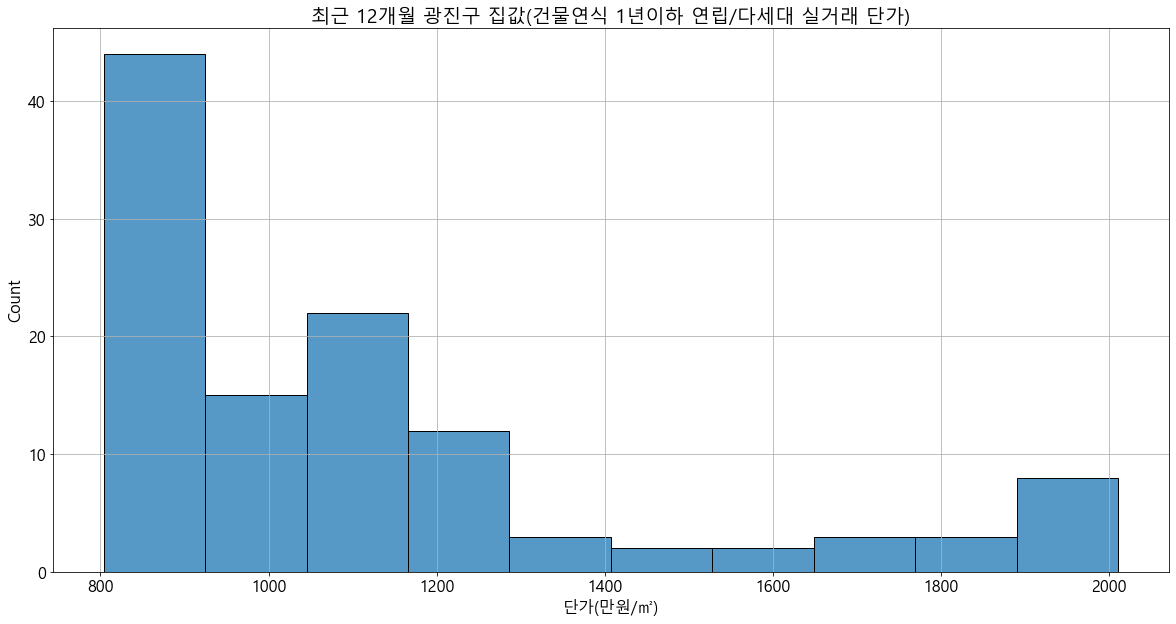

count     114.000000
mean     1126.494319
std       325.595642
min       803.824363
25%       890.595388
50%      1012.145749
75%      1213.424459
max      2010.619469
Name: 단가(만원/㎡), dtype: float64
count     333.000000
mean      907.636982
std       409.318171
min        50.280000
25%       684.500000
50%       898.311175
75%      1058.761249
max      2972.399151
Name: 단가(만원/㎡), dtype: float64
구로구
제2종일반주거지역    0.557169
제3종일반주거지역    0.168579
준공업지역        0.116077
제1종일반주거지역    0.041483
준주거지역        0.037845
개발제한구역       0.033780
일반상업지역       0.025703
자연녹지지역       0.019230
생산녹지지역       0.000134
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

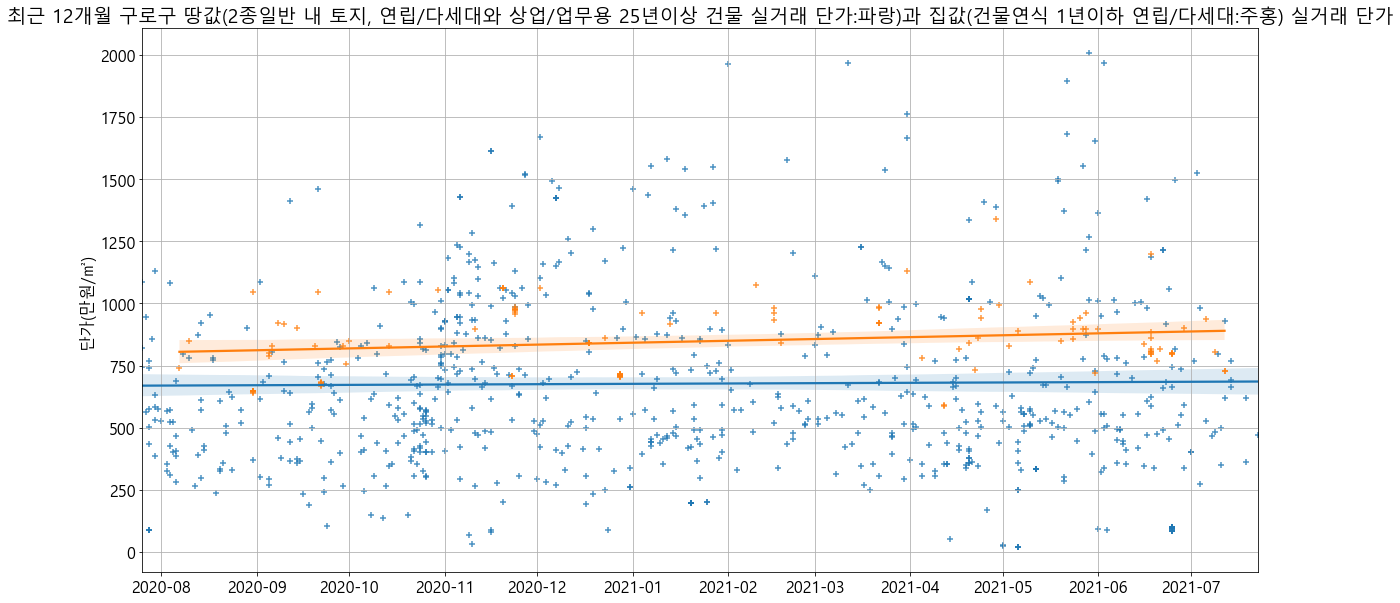

<Figure size 432x288 with 0 Axes>

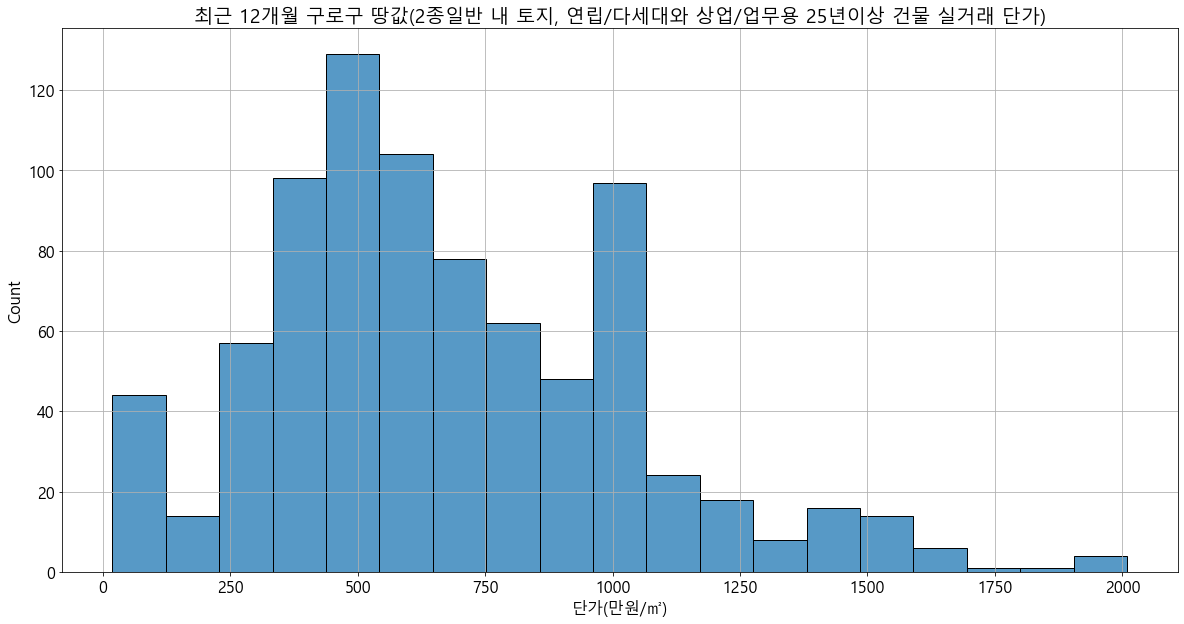

<Figure size 432x288 with 0 Axes>

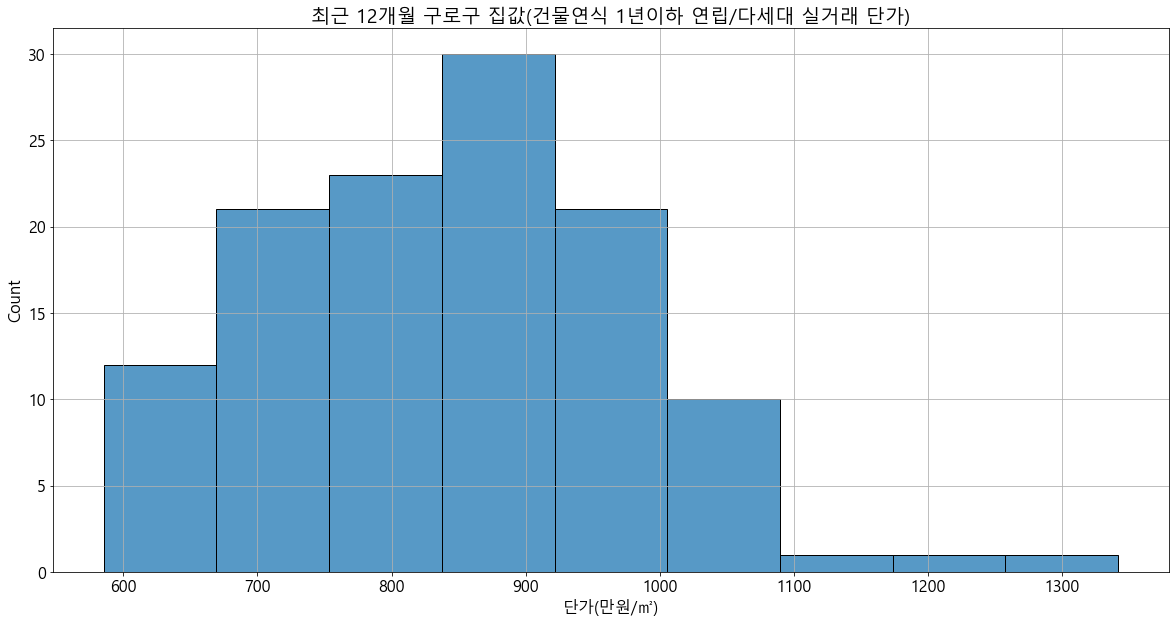

count     120.000000
mean      849.028040
std       137.345528
min       585.267407
25%       729.096990
50%       842.736248
75%       942.443622
max      1342.113515
Name: 단가(만원/㎡), dtype: float64
count     823.000000
mean      677.522612
std       355.636967
min        19.066667
25%       431.222157
50%       607.128868
75%       928.023069
max      2008.928571
Name: 단가(만원/㎡), dtype: float64
금천구
제2종일반주거지역    0.606128
준공업지역        0.167313
제1종일반주거지역    0.107195
준주거지역        0.042713
제3종일반주거지역    0.032338
일반상업지역       0.015563
개발제한구역       0.013818
자연녹지지역       0.009793
근린상업지역       0.005139
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

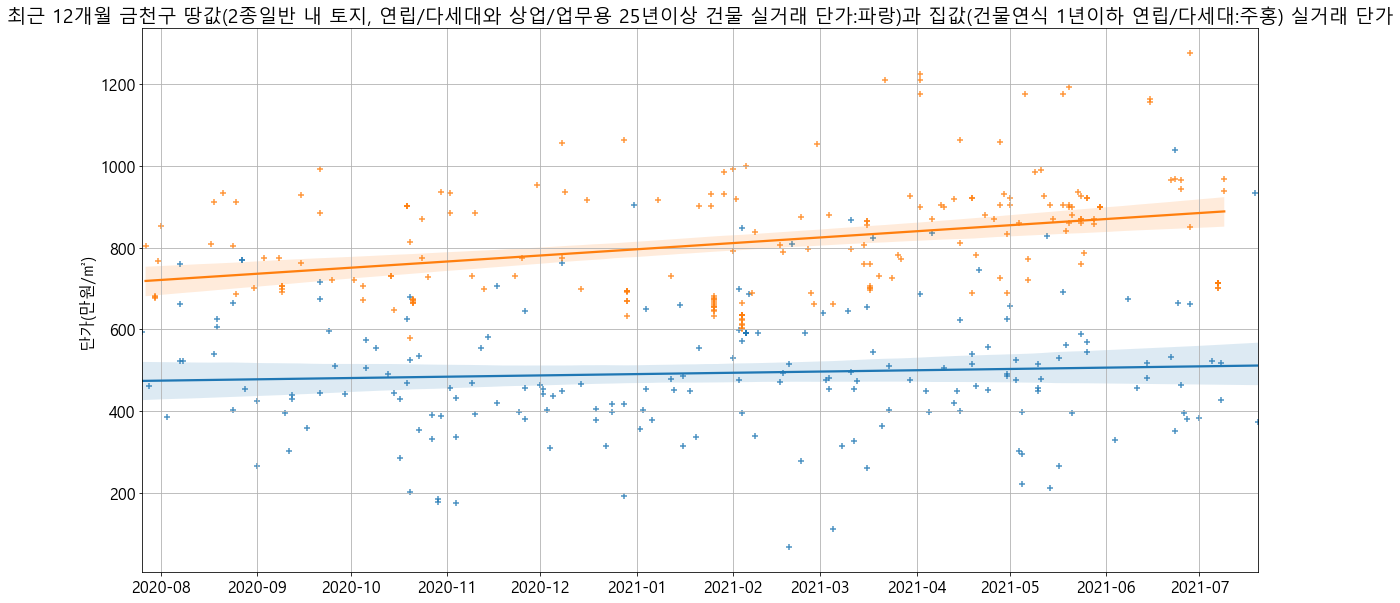

<Figure size 432x288 with 0 Axes>

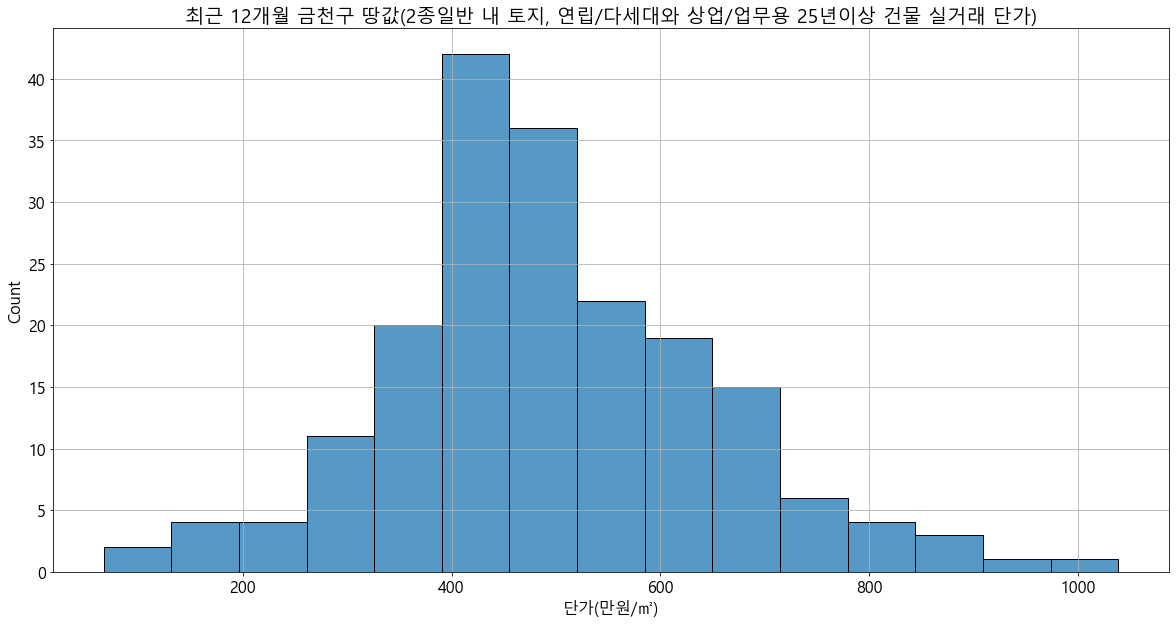

<Figure size 432x288 with 0 Axes>

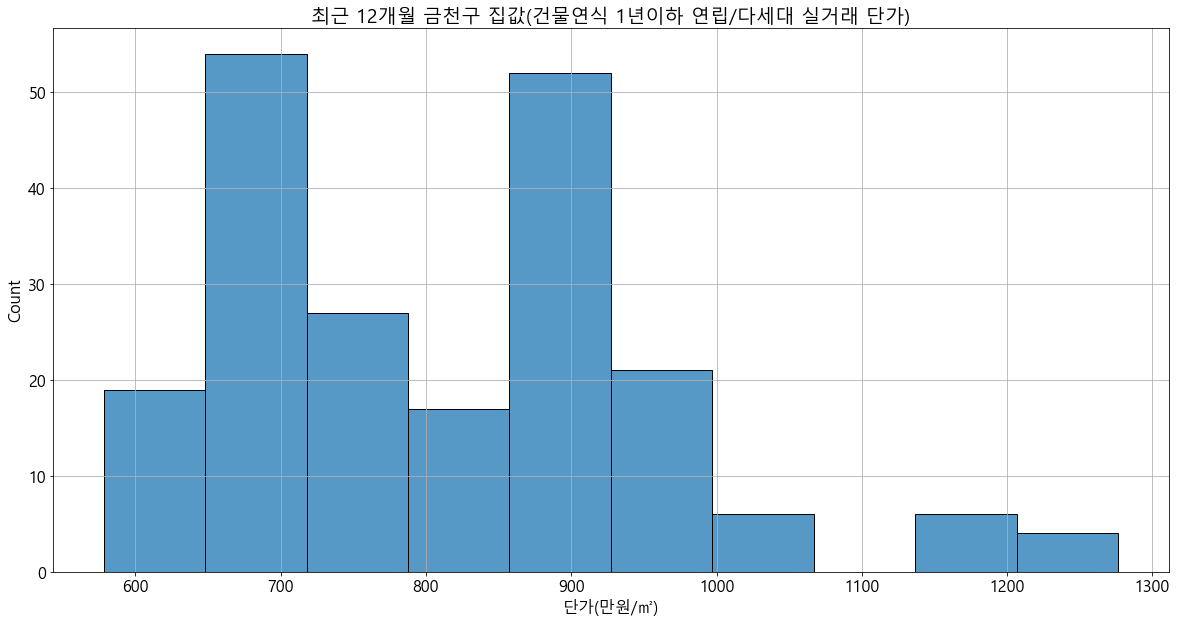

count     206.000000
mean      814.984525
std       145.096087
min       578.155029
25%       693.564522
50%       796.460586
75%       903.290799
max      1276.448144
Name: 단가(만원/㎡), dtype: float64
count     190.000000
mean      492.673677
std       156.694661
min        66.666667
25%       397.402410
50%       472.290405
75%       589.572686
max      1038.618374
Name: 단가(만원/㎡), dtype: float64
노원구
제2종일반주거지역    0.522110
제3종일반주거지역    0.196204
자연녹지지역       0.107321
개발제한구역       0.062756
제1종일반주거지역    0.053537
준주거지역        0.039734
일반상업지역       0.014740
제1종전용주거지역    0.003402
제2종전용주거지역    0.000197
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

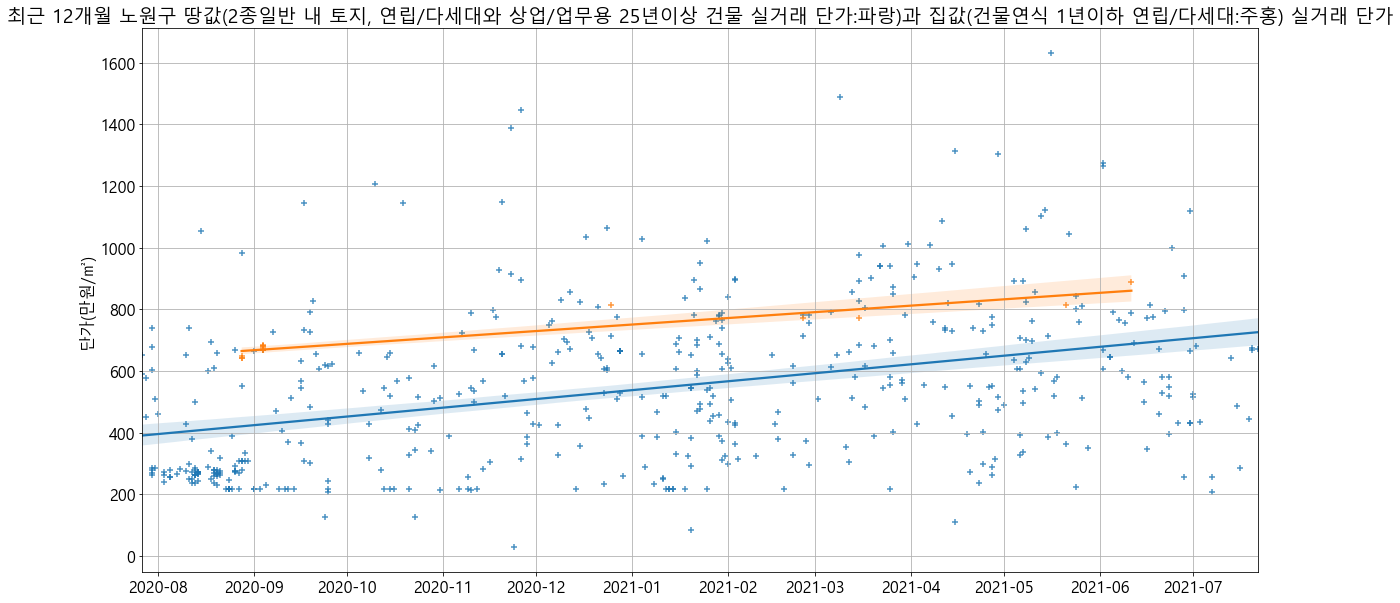

<Figure size 432x288 with 0 Axes>

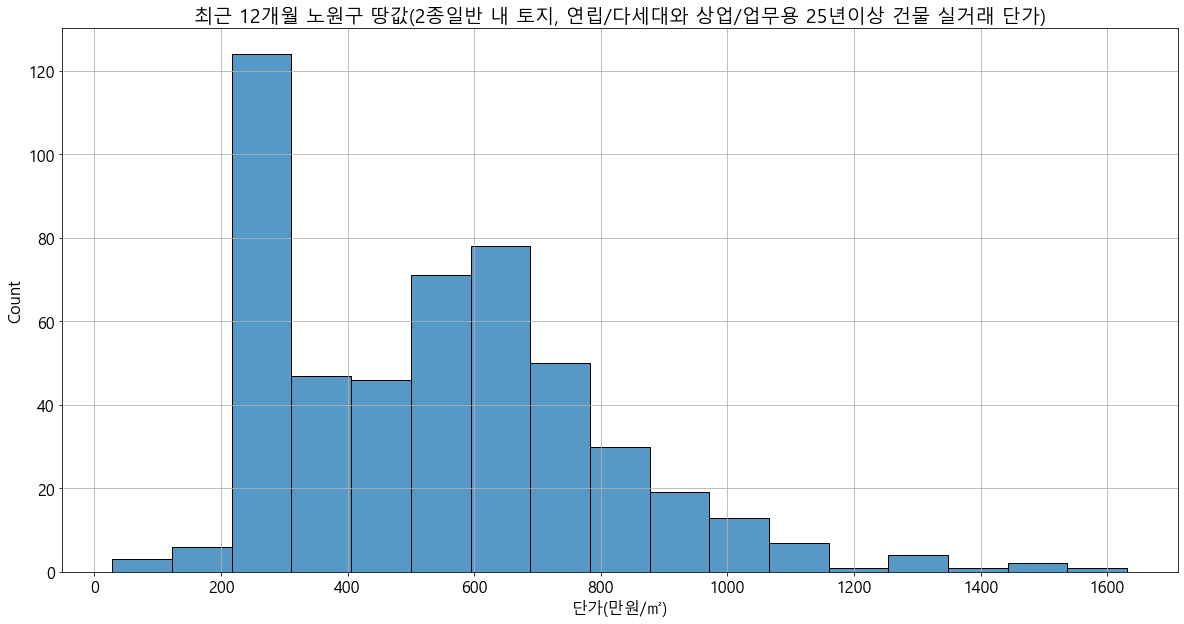

<Figure size 432x288 with 0 Axes>

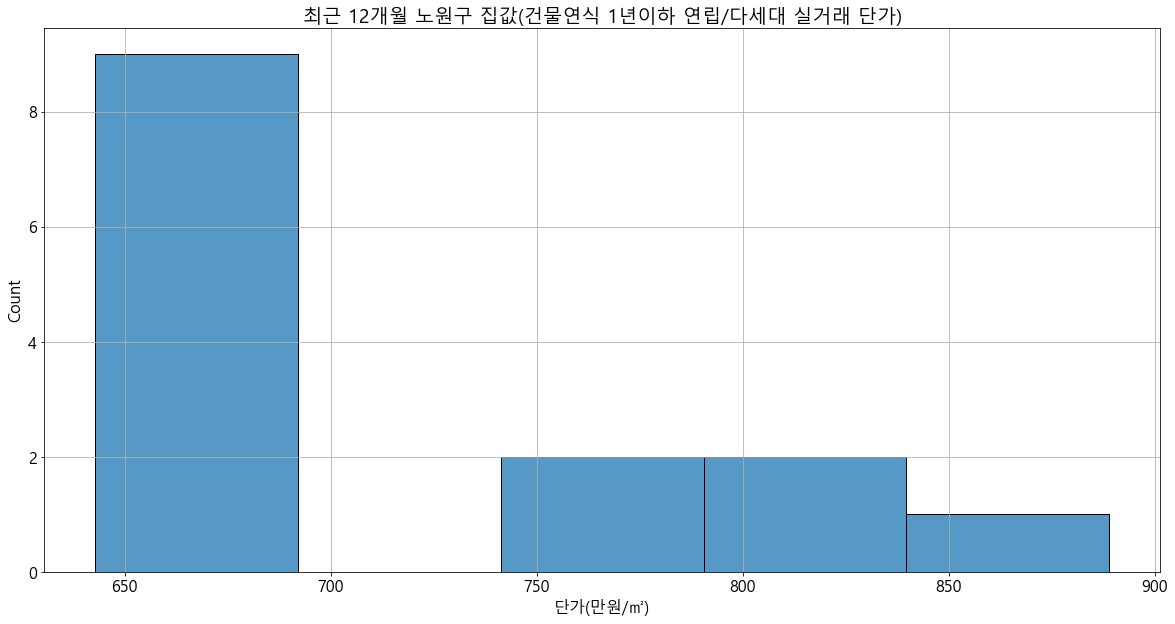

count     14.000000
mean     717.729110
std       78.991716
min      642.785403
25%      667.001003
50%      680.413901
75%      771.553170
max      888.963435
Name: 단가(만원/㎡), dtype: float64
count     503.000000
mean      540.584373
std       257.500992
min        28.571429
25%       306.925518
50%       524.737631
75%       692.940507
max      1631.205674
Name: 단가(만원/㎡), dtype: float64
도봉구
제2종일반주거지역    0.513204
제1종일반주거지역    0.136261
제3종일반주거지역    0.099616
준공업지역        0.098780
개발제한구역       0.070784
준주거지역        0.036520
자연녹지지역       0.030085
일반상업지역       0.013705
근린상업지역       0.001045
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

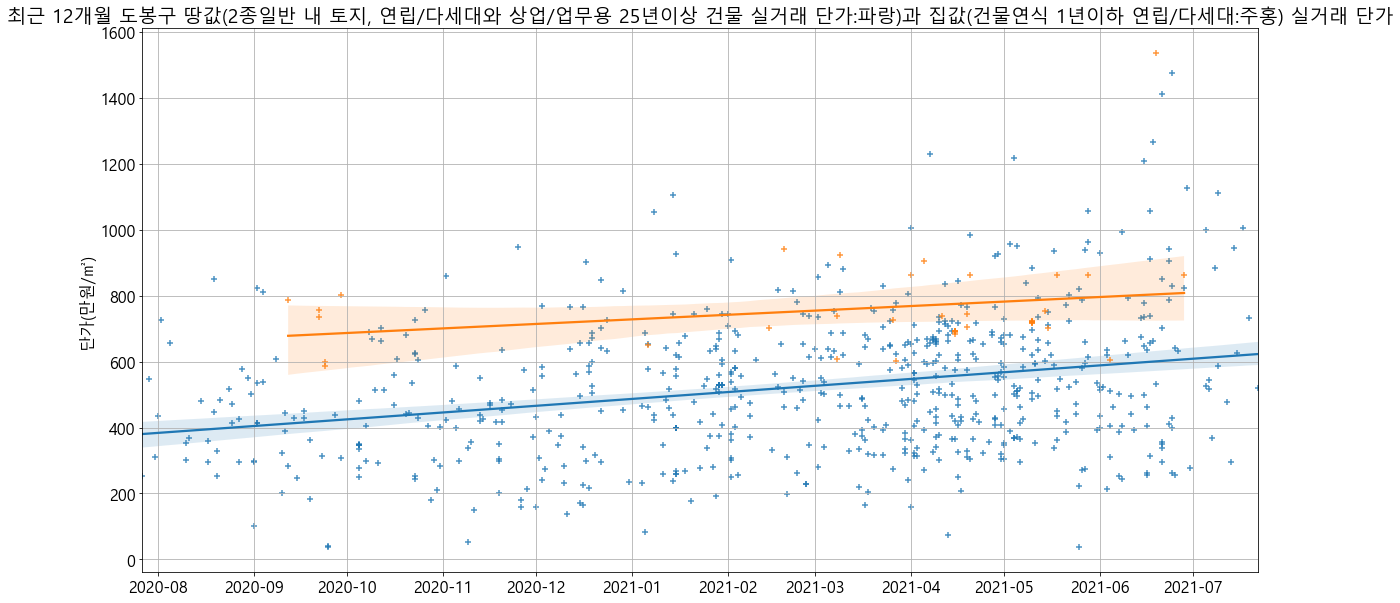

<Figure size 432x288 with 0 Axes>

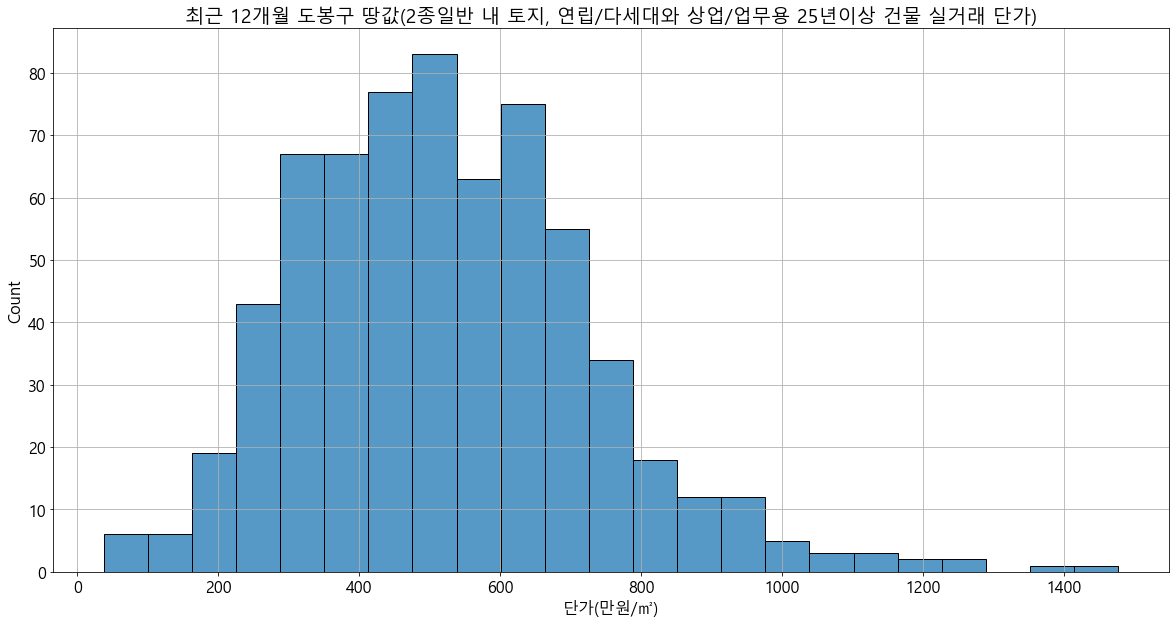

<Figure size 432x288 with 0 Axes>

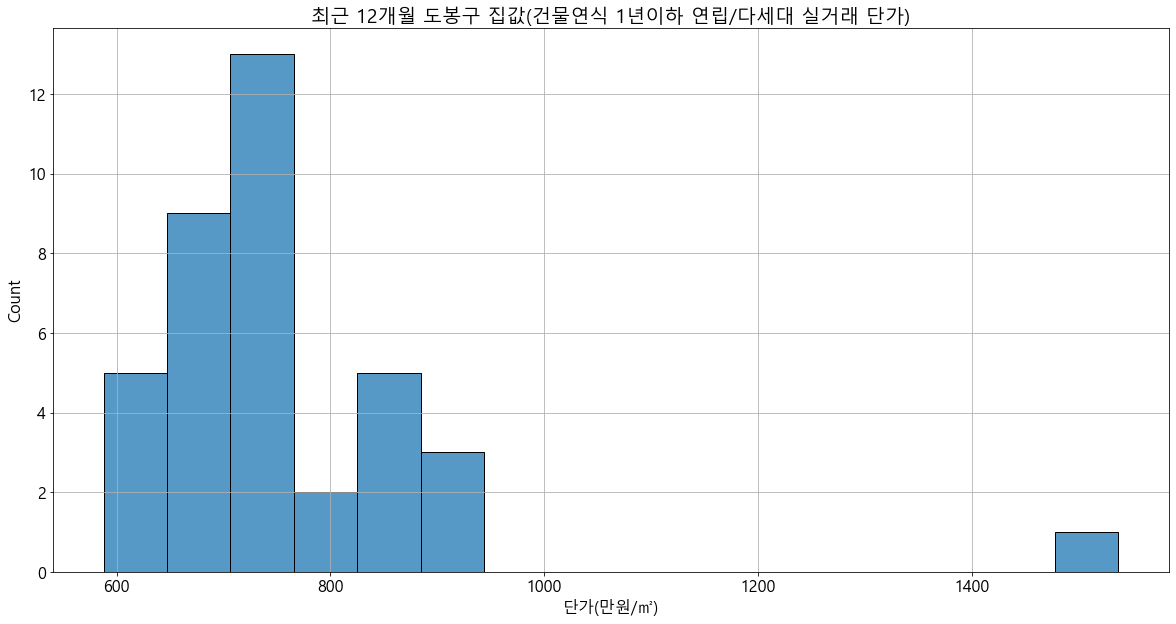

count      38.000000
mean      761.627548
std       158.144295
min       587.719298
25%       694.027361
50%       723.860590
75%       798.393674
max      1536.849459
Name: 단가(만원/㎡), dtype: float64
count     654.000000
mean      523.079696
std       208.793514
min        37.267081
25%       370.943569
50%       508.591020
75%       653.018002
max      1476.503597
Name: 단가(만원/㎡), dtype: float64
동대문구
제2종일반주거지역    0.658510
제3종일반주거지역    0.187740
준주거지역        0.052489
일반상업지역       0.047833
제1종일반주거지역    0.043427
근린상업지역       0.006410
자연녹지지역       0.003445
유통상업지역       0.000146
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

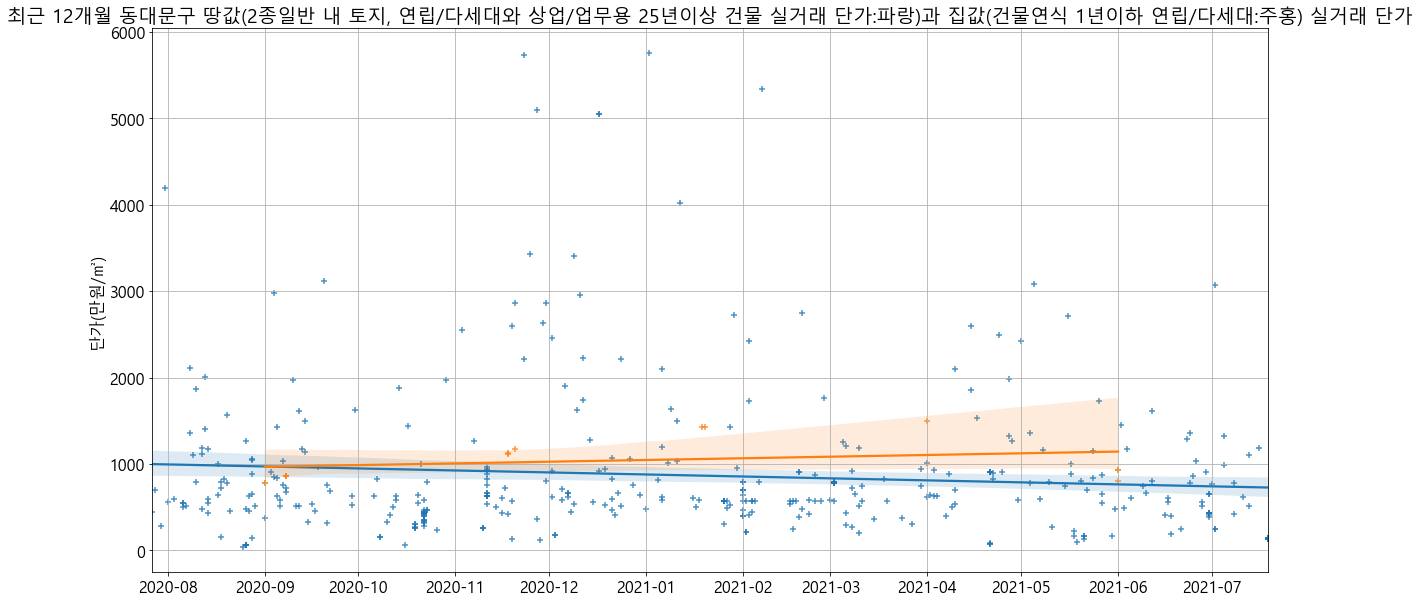

<Figure size 432x288 with 0 Axes>

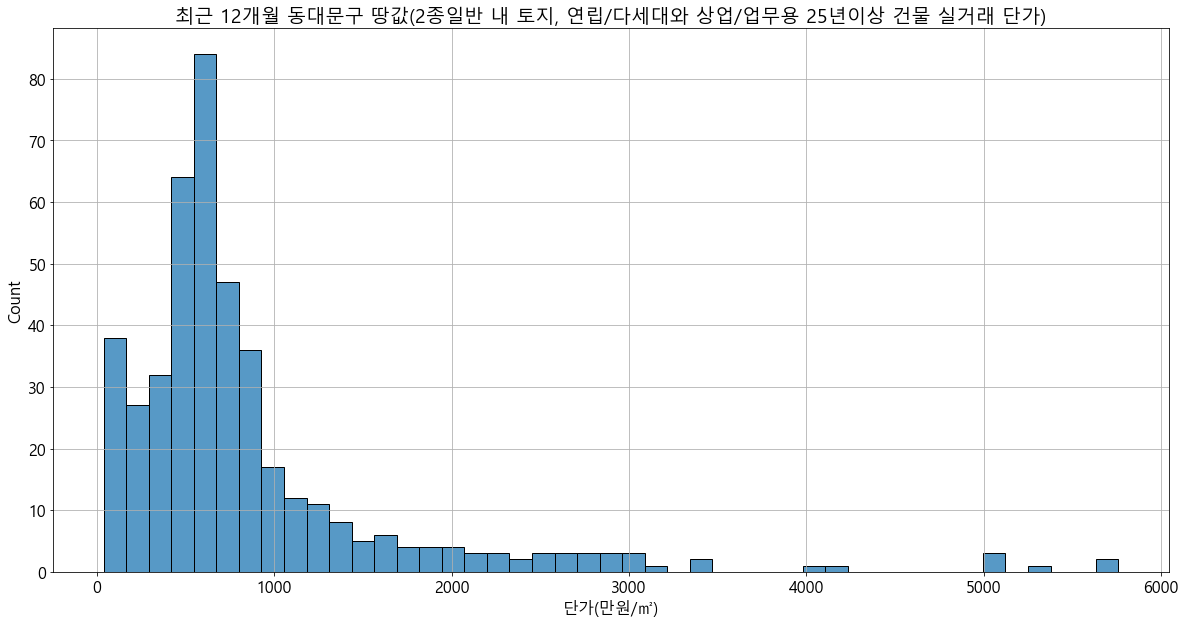

<Figure size 432x288 with 0 Axes>

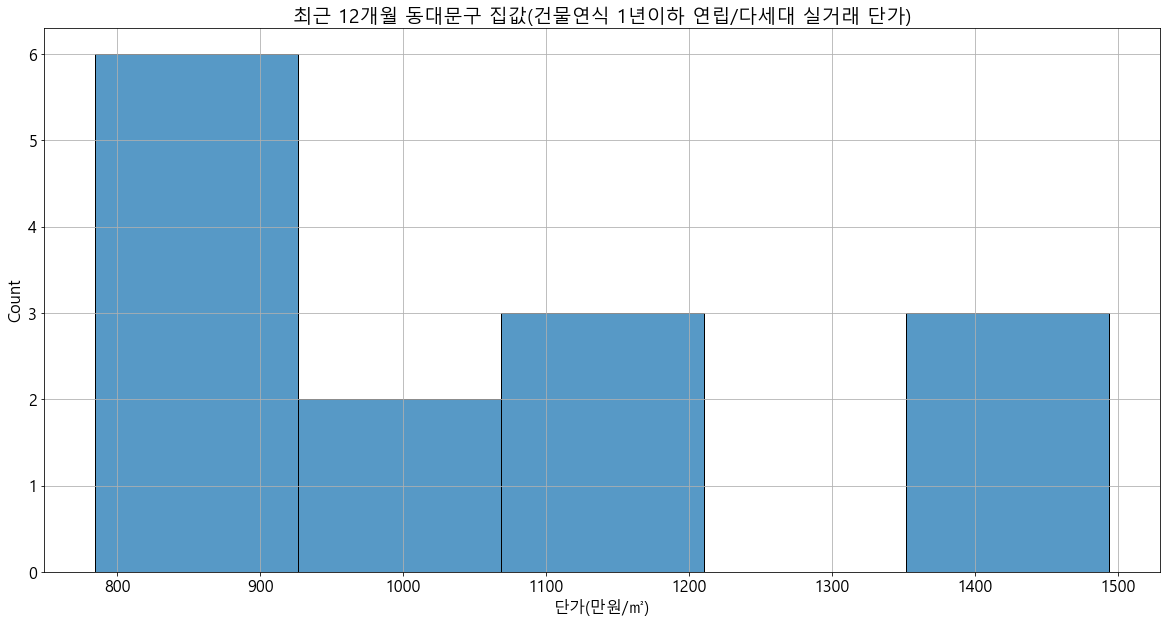

count      14.000000
mean     1039.793985
std       255.409394
min       784.249919
25%       857.394798
50%       926.975659
75%      1161.423738
max      1493.627191
Name: 단가(만원/㎡), dtype: float64
count     433.000000
mean      865.442905
std       843.247517
min        38.095238
25%       434.450000
50%       632.262474
75%       917.026379
max      5757.575758
Name: 단가(만원/㎡), dtype: float64
동작구
제2종일반주거지역    0.578469
제3종일반주거지역    0.227138
제1종일반주거지역    0.128928
일반상업지역       0.024311
준주거지역        0.020872
자연녹지지역       0.015948
근린상업지역       0.003581
유통상업지역       0.000754
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

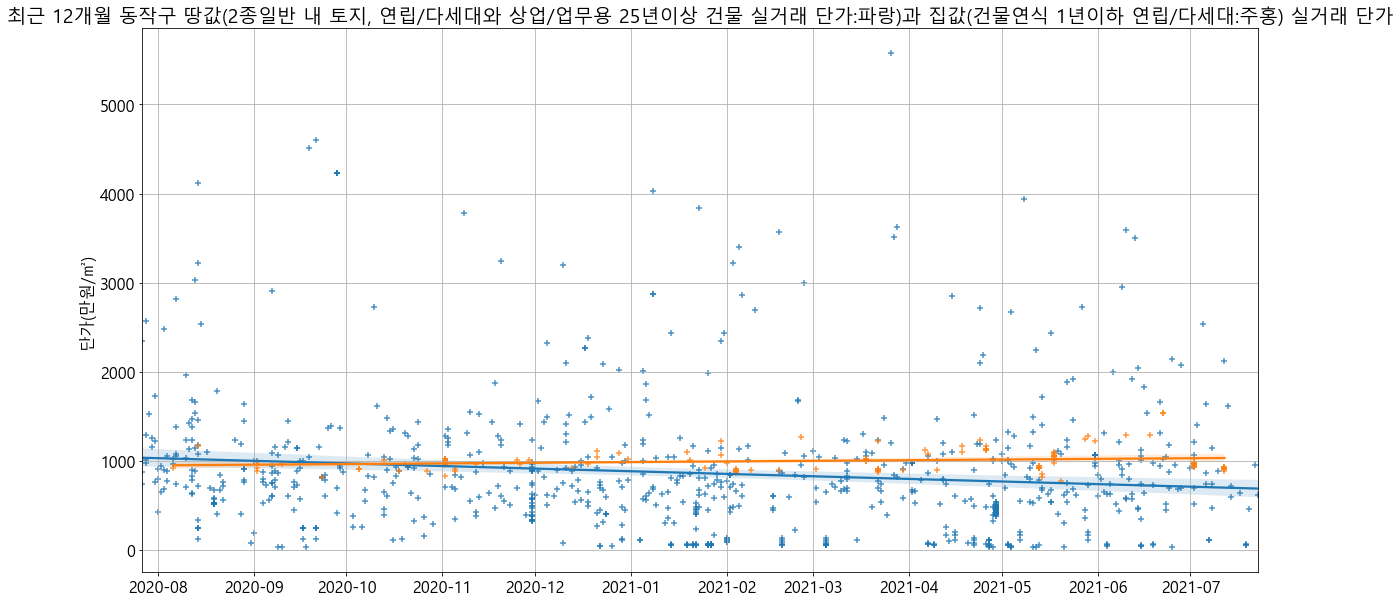

<Figure size 432x288 with 0 Axes>

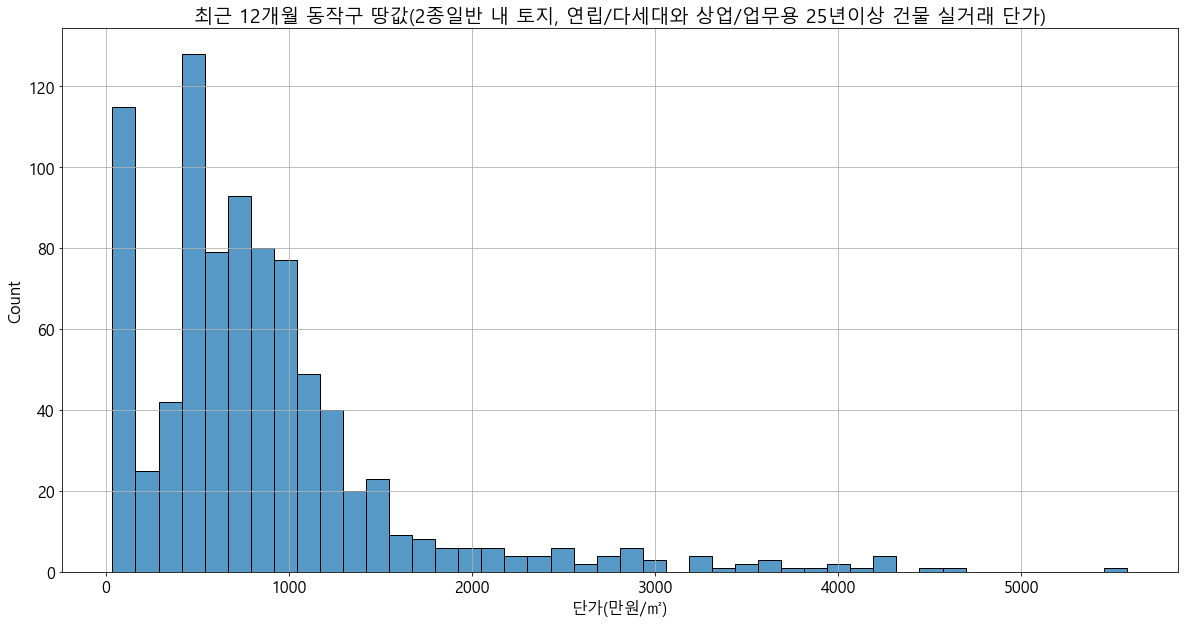

<Figure size 432x288 with 0 Axes>

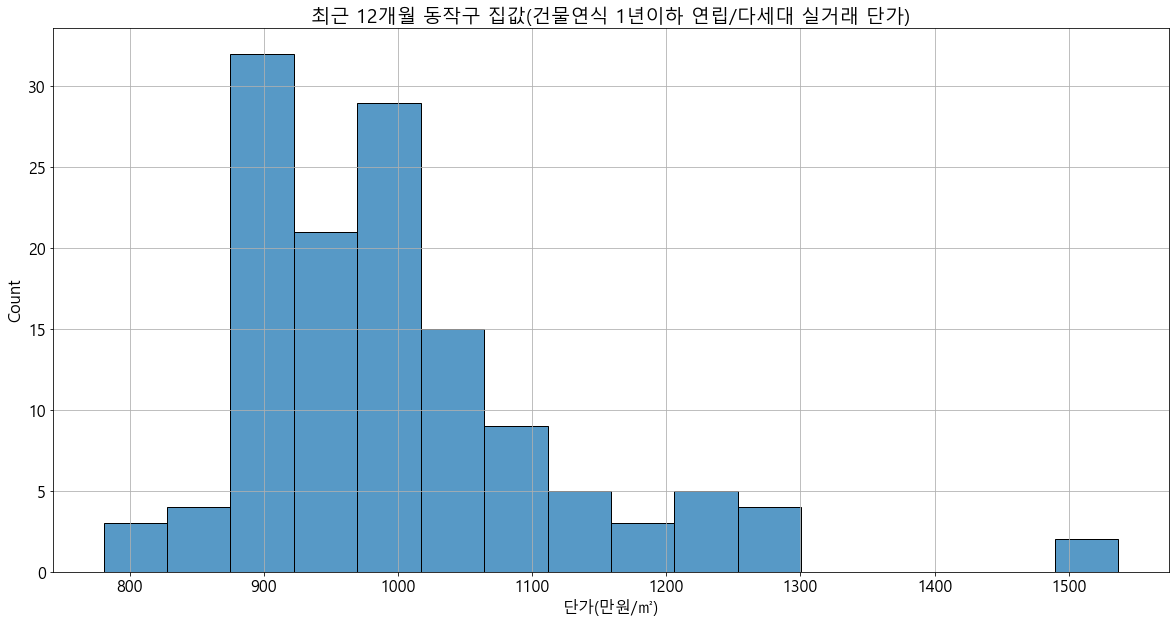

count     132.000000
mean     1001.136438
std       123.660079
min       780.454700
25%       916.690193
50%       974.820525
75%      1038.341574
max      1536.919479
Name: 단가(만원/㎡), dtype: float64
count     857.000000
mean      861.824531
std       742.971217
min        34.115994
25%       451.544944
50%       713.415695
75%      1054.054054
max      5576.916181
Name: 단가(만원/㎡), dtype: float64
마포구
제2종일반주거지역    0.679573
제3종일반주거지역    0.175468
준주거지역        0.053293
자연녹지지역       0.040928
일반상업지역       0.028319
제1종일반주거지역    0.014717
근린상업지역       0.005372
유통상업지역       0.001358
개발제한구역       0.000973
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

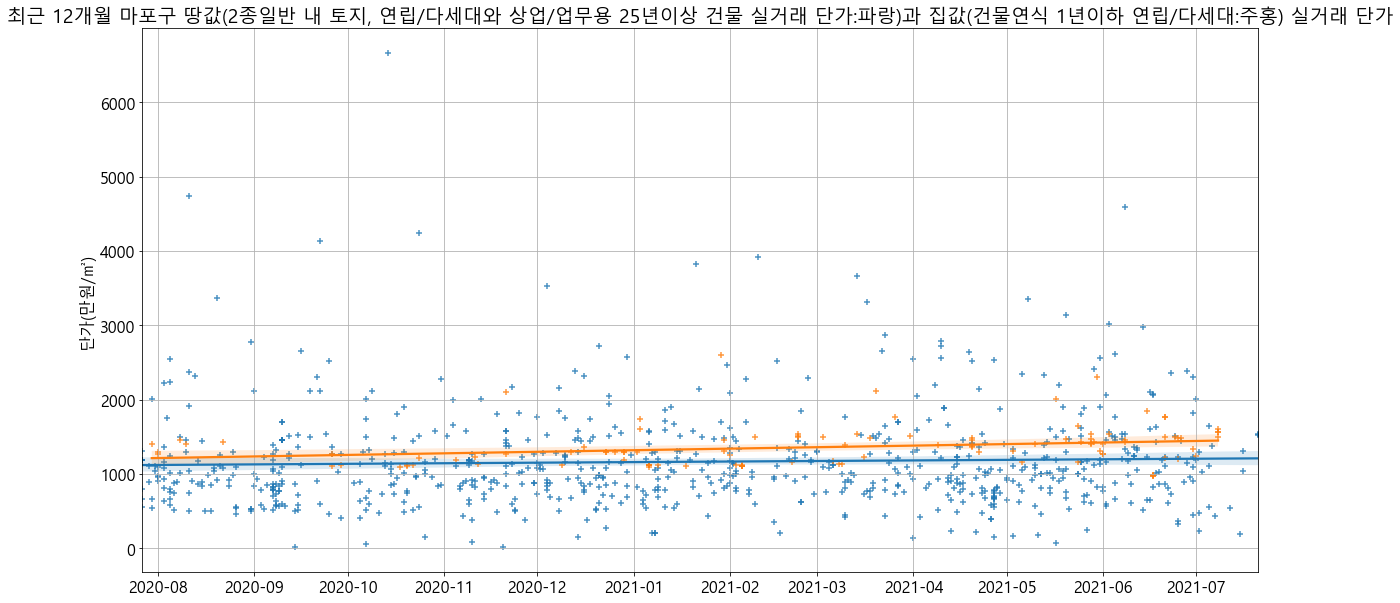

<Figure size 432x288 with 0 Axes>

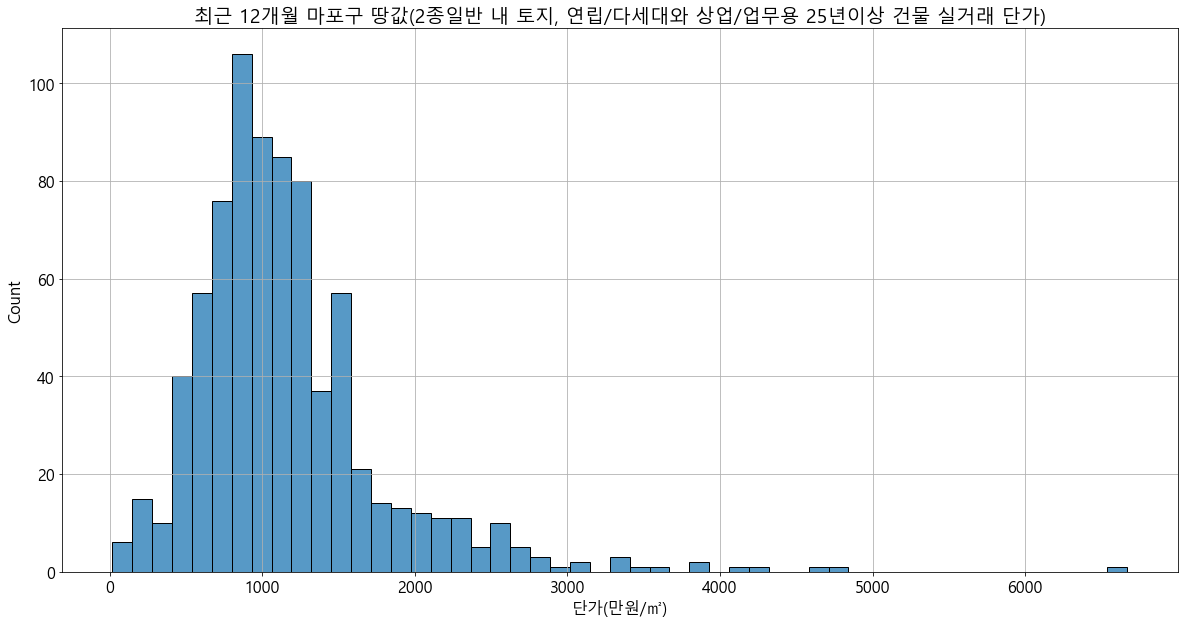

<Figure size 432x288 with 0 Axes>

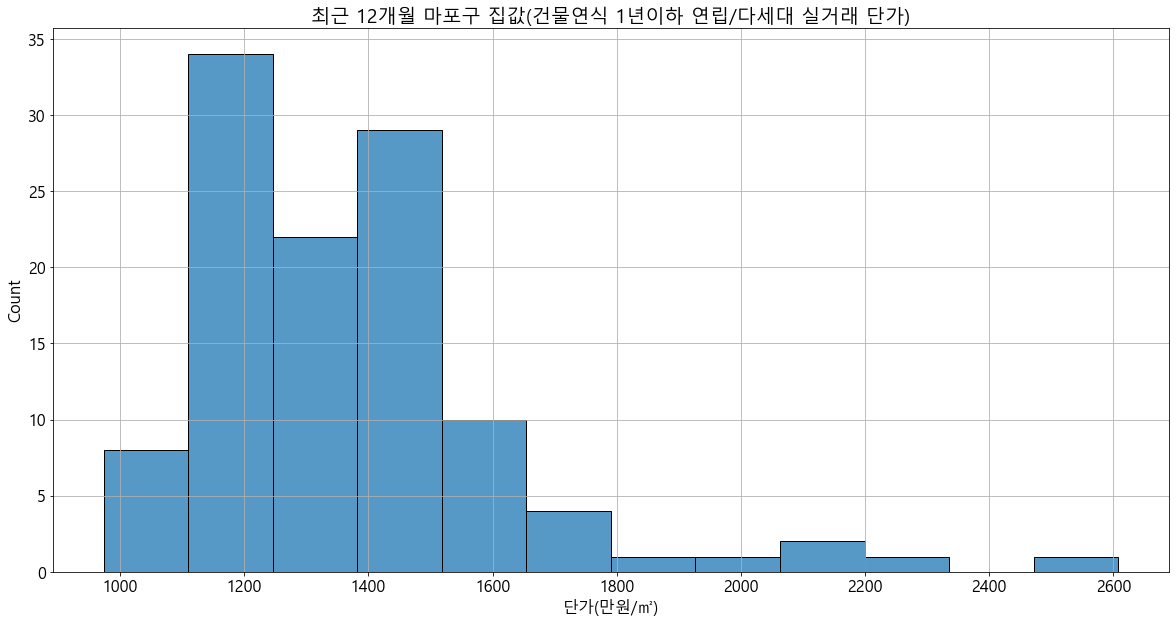

count     113.000000
mean     1362.726182
std       270.159659
min       973.613894
25%      1132.404181
50%      1302.435724
75%      1484.584450
max      2607.823470
Name: 단가(만원/㎡), dtype: float64
count     778.000000
mean     1166.568075
std       643.148257
min        18.910741
25%       790.866928
50%      1044.772560
75%      1395.541869
max      6666.666667
Name: 단가(만원/㎡), dtype: float64
서대문구
제2종일반주거지역    0.543558
제3종일반주거지역    0.198496
제1종일반주거지역    0.151040
준주거지역        0.046004
일반상업지역       0.026692
제1종전용주거지역    0.021083
개발제한구역       0.009249
자연녹지지역       0.003023
근린상업지역       0.000855
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

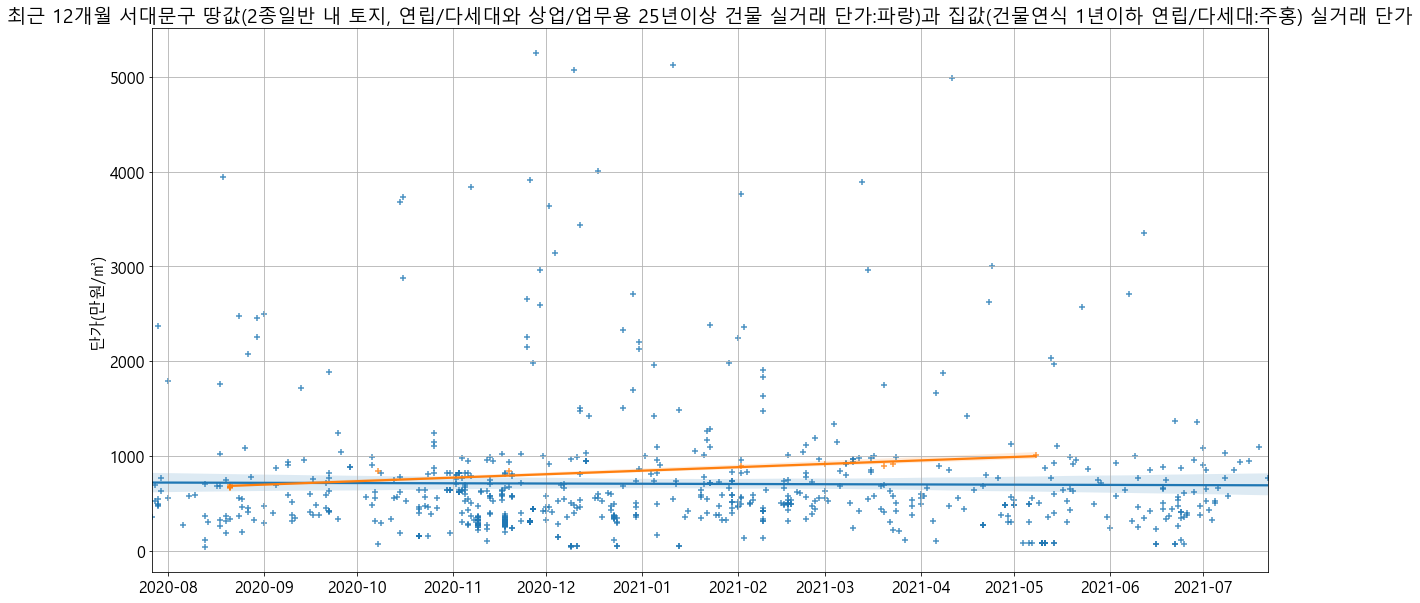

<Figure size 432x288 with 0 Axes>

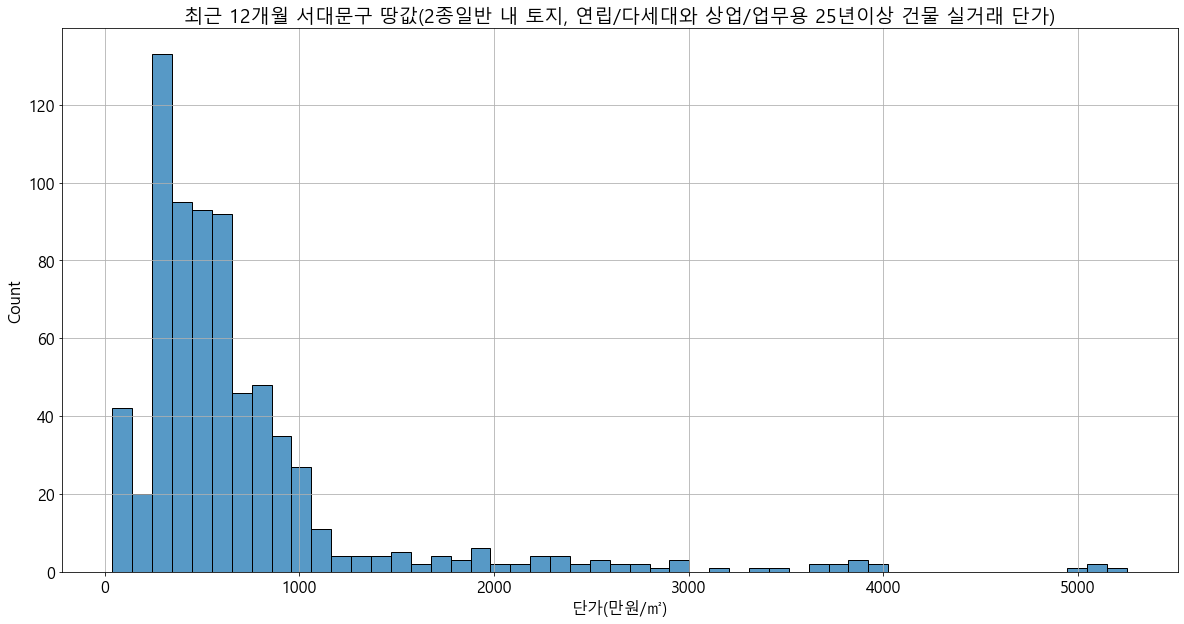

<Figure size 432x288 with 0 Axes>

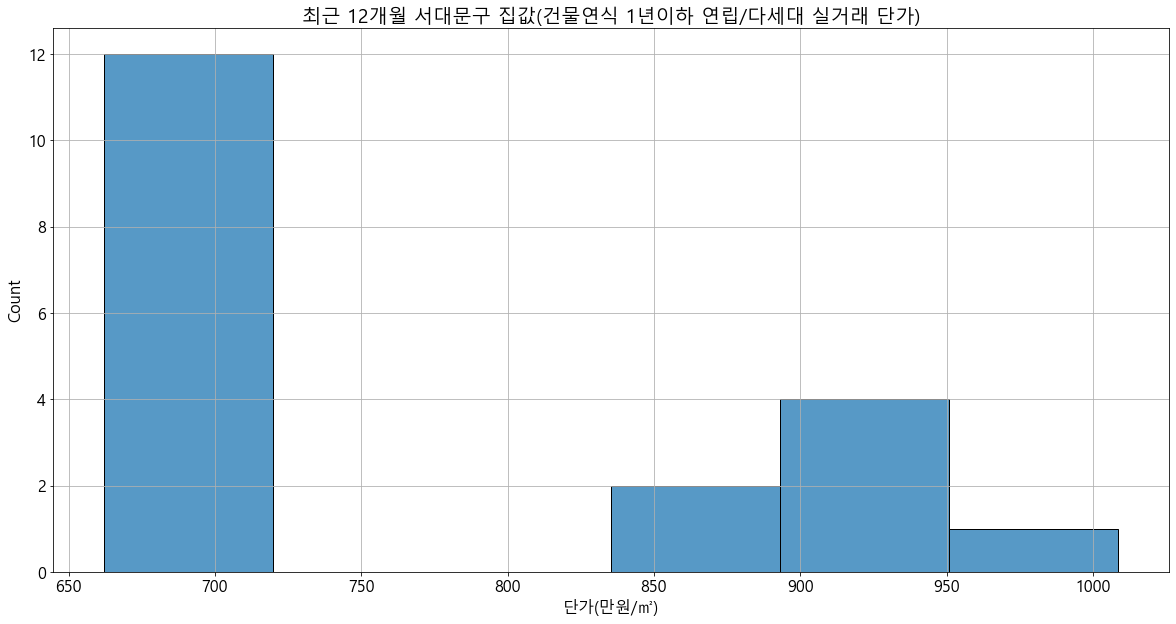

count      19.000000
mean      759.540739
std       117.670814
min       661.934632
25%       675.000000
50%       677.271236
75%       869.637964
max      1008.597884
Name: 단가(만원/㎡), dtype: float64
count     715.000000
mean      706.713011
std       707.298533
min        39.000000
25%       324.906532
50%       516.845329
75%       788.332665
max      5252.659574
Name: 단가(만원/㎡), dtype: float64
서초구
제2종일반주거지역    0.370525
개발제한구역       0.225410
제3종일반주거지역    0.182405
제1종일반주거지역    0.069611
제1종전용주거지역    0.061308
자연녹지지역       0.045296
일반상업지역       0.039731
준주거지역        0.005714
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

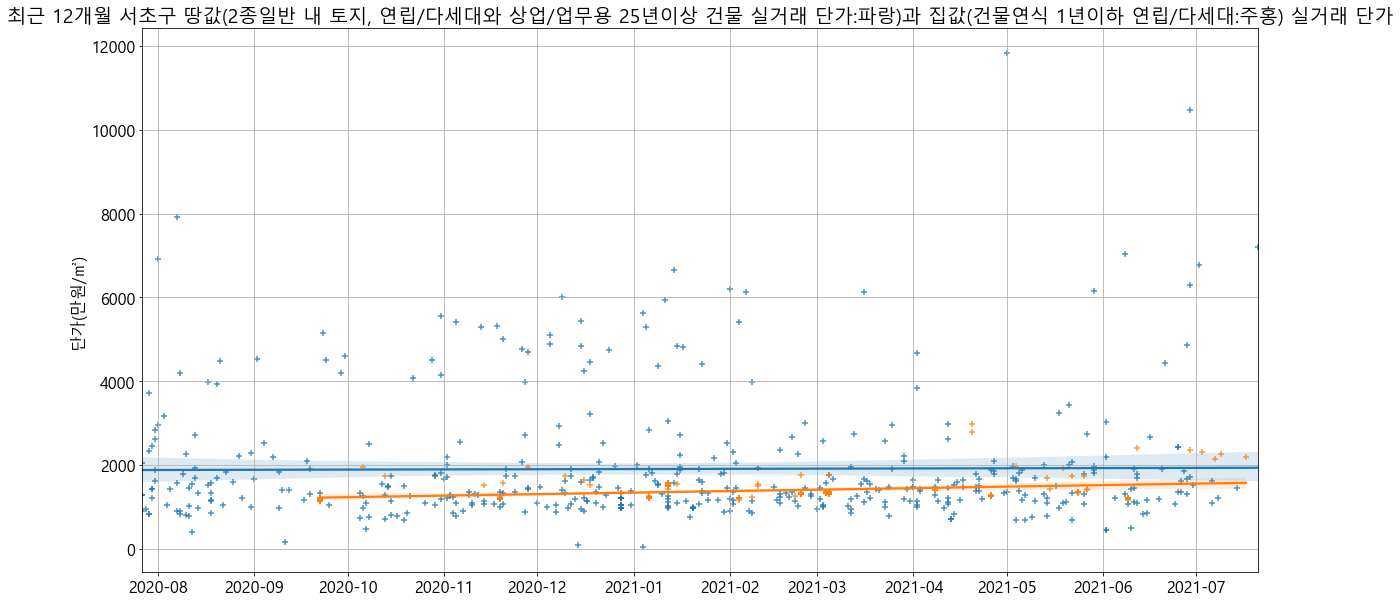

<Figure size 432x288 with 0 Axes>

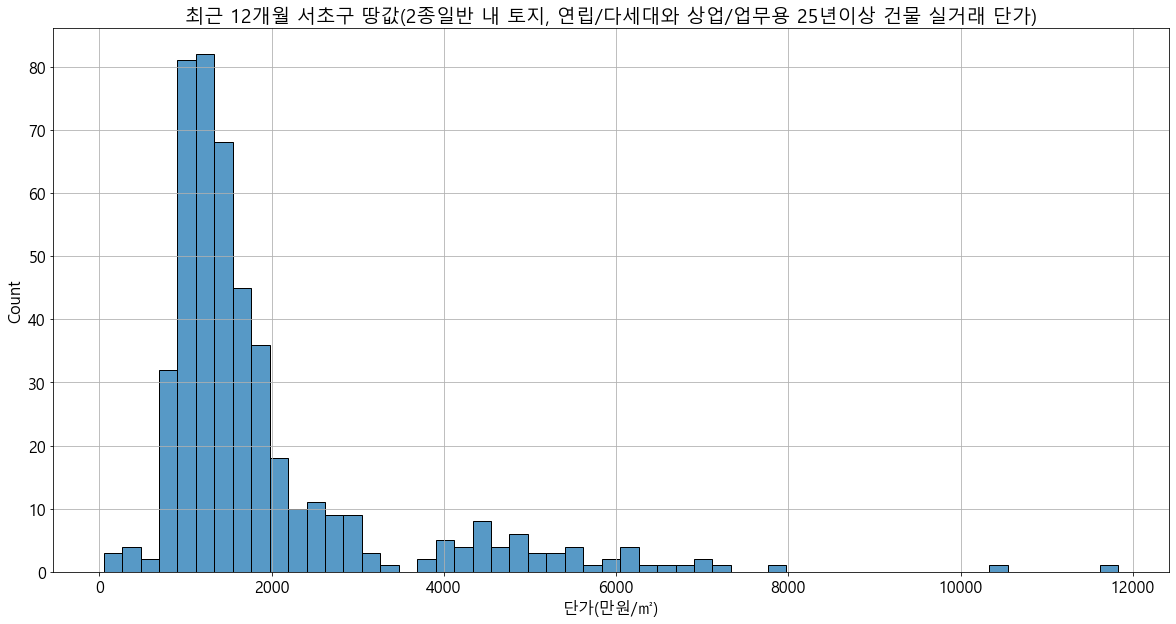

<Figure size 432x288 with 0 Axes>

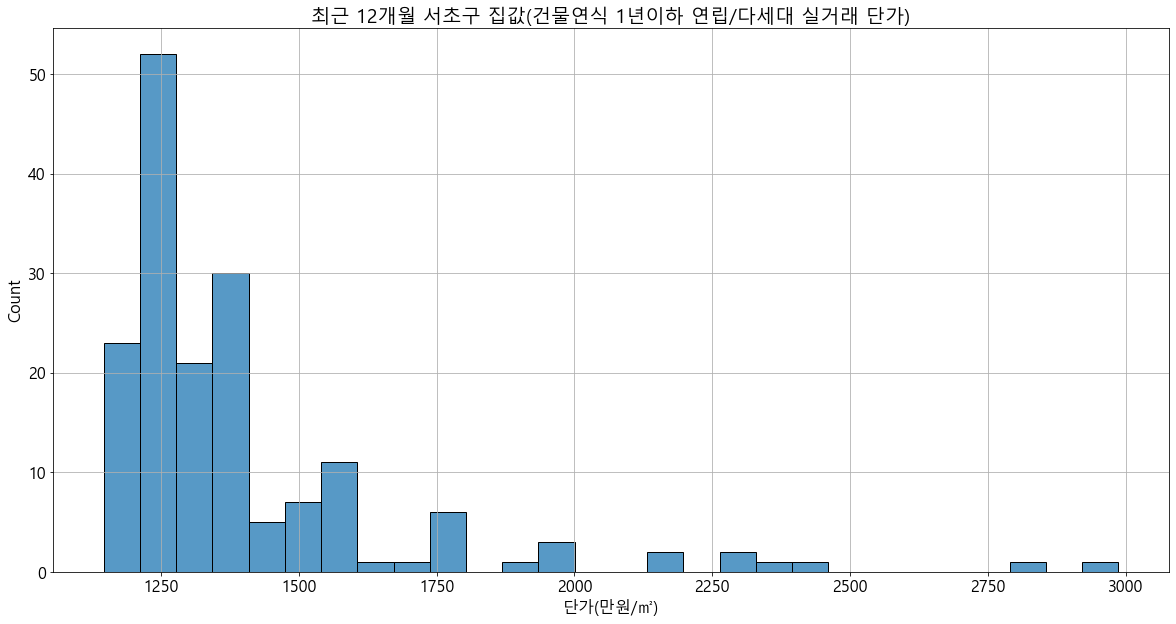

count     169.000000
mean     1399.735468
std       291.796398
min      1145.868183
25%      1224.149433
50%      1322.823852
75%      1410.175879
max      2986.611740
Name: 단가(만원/㎡), dtype: float64
count      469.000000
mean      1911.898445
std       1448.871371
min         48.851979
25%       1109.215017
50%       1426.101988
75%       1954.308418
max      11829.573935
Name: 단가(만원/㎡), dtype: float64
성북구
제2종일반주거지역    0.598666
제3종일반주거지역    0.138970
제1종일반주거지역    0.128011
준주거지역        0.051691
제1종전용주거지역    0.034504
일반상업지역       0.026963
자연녹지지역       0.011124
개발제한구역       0.005356
근린상업지역       0.004716
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

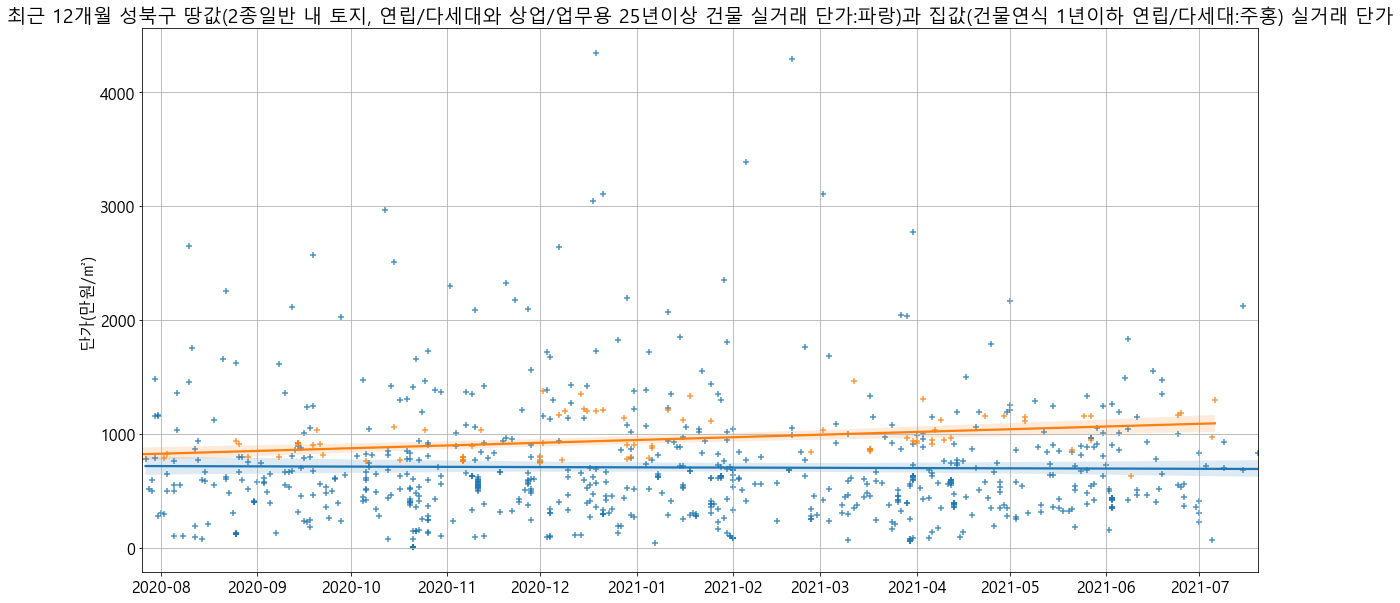

<Figure size 432x288 with 0 Axes>

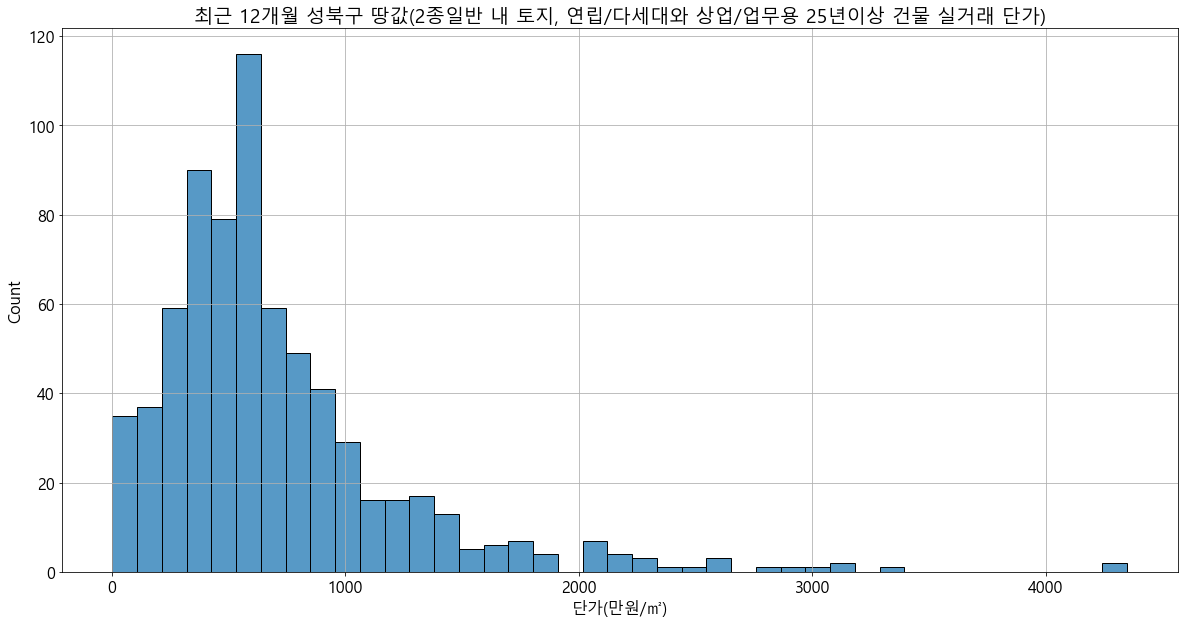

<Figure size 432x288 with 0 Axes>

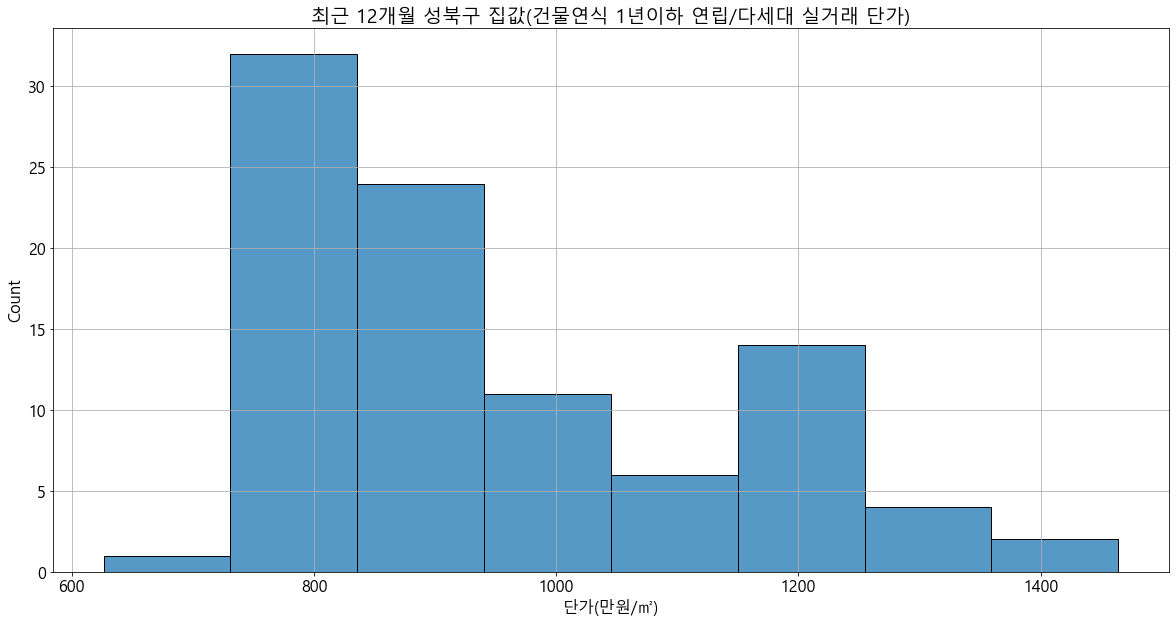

count      94.000000
mean      948.050556
std       184.244361
min       626.304802
25%       791.209365
50%       910.058910
75%      1115.425100
max      1464.002756
Name: 단가(만원/㎡), dtype: float64
count     705.000000
mean      704.313203
std       539.642125
min         3.958515
25%       385.000000
50%       586.845215
75%       862.688713
max      4347.801418
Name: 단가(만원/㎡), dtype: float64
송파구
제2종일반주거지역    0.636650
제3종일반주거지역    0.194431
자연녹지지역       0.052236
제1종일반주거지역    0.041237
준주거지역        0.028269
개발제한구역       0.019937
일반상업지역       0.018634
생산녹지지역       0.007363
유통상업지역       0.001000
근린상업지역       0.000242
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

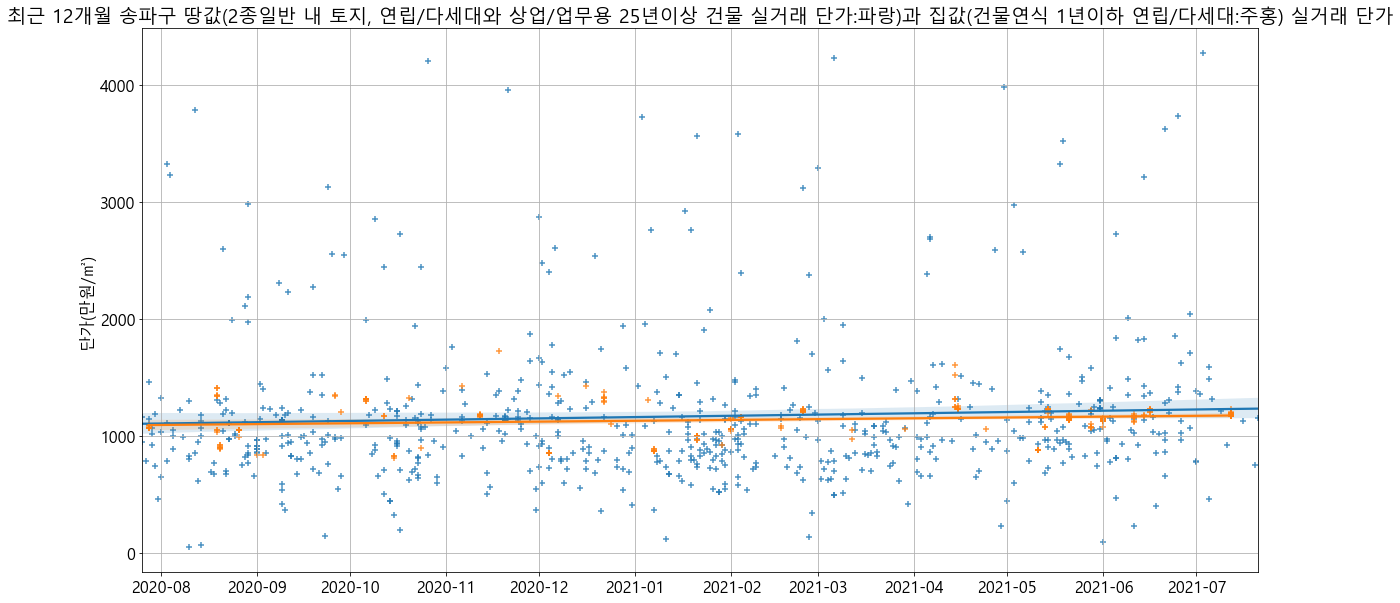

<Figure size 432x288 with 0 Axes>

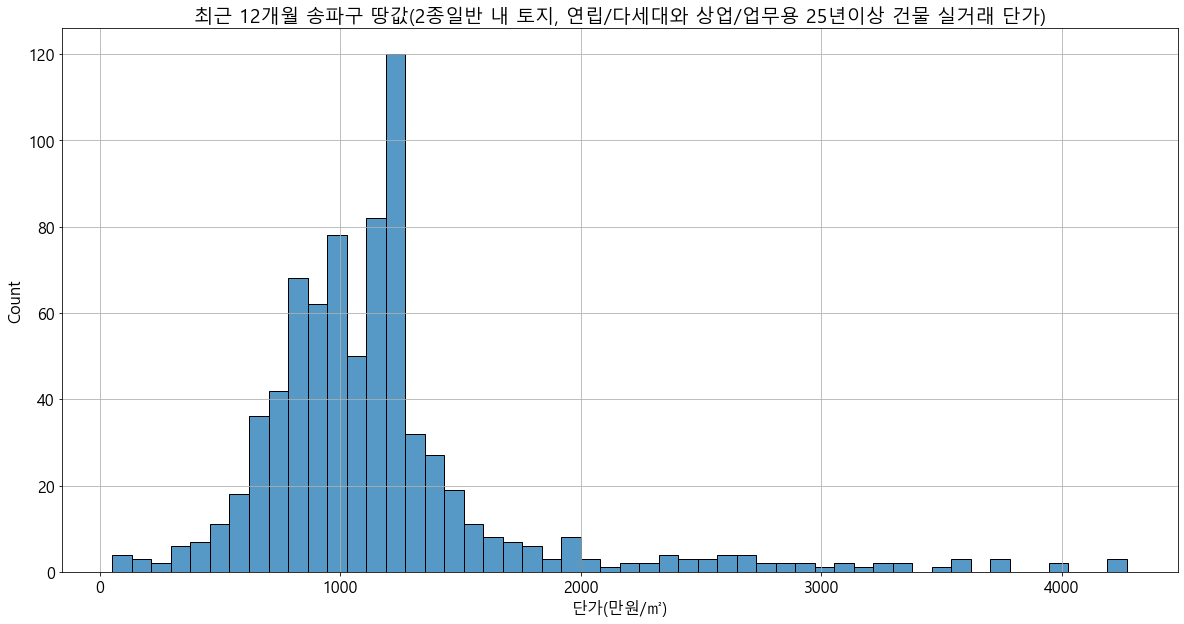

<Figure size 432x288 with 0 Axes>

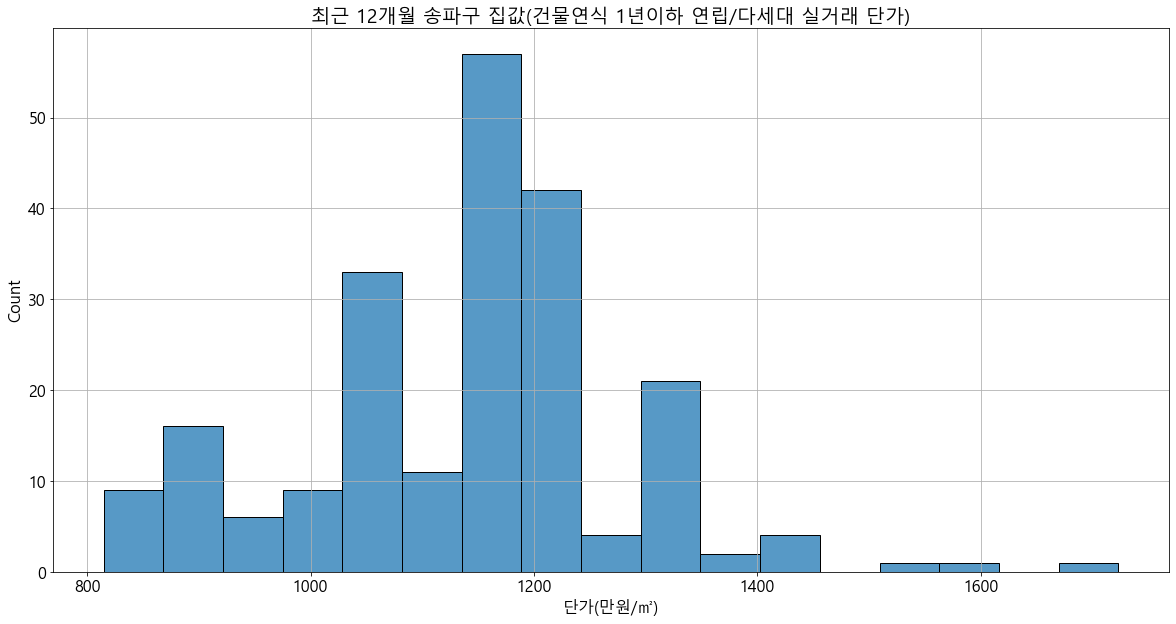

count     217.000000
mean     1138.879944
std       146.285096
min       814.876033
25%      1058.823529
50%      1162.479062
75%      1219.843697
max      1722.961447
Name: 단가(만원/㎡), dtype: float64
count     762.000000
mean     1170.618593
std       583.693245
min        51.161363
25%       857.338305
50%      1090.284122
75%      1230.818414
max      4272.397721
Name: 단가(만원/㎡), dtype: float64
양천구
제2종일반주거지역    0.663748
제3종일반주거지역    0.181202
제1종일반주거지역    0.064732
준주거지역        0.037693
자연녹지지역       0.026151
일반상업지역       0.010735
근린상업지역       0.007950
개발제한구역       0.007345
준공업지역        0.000444
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

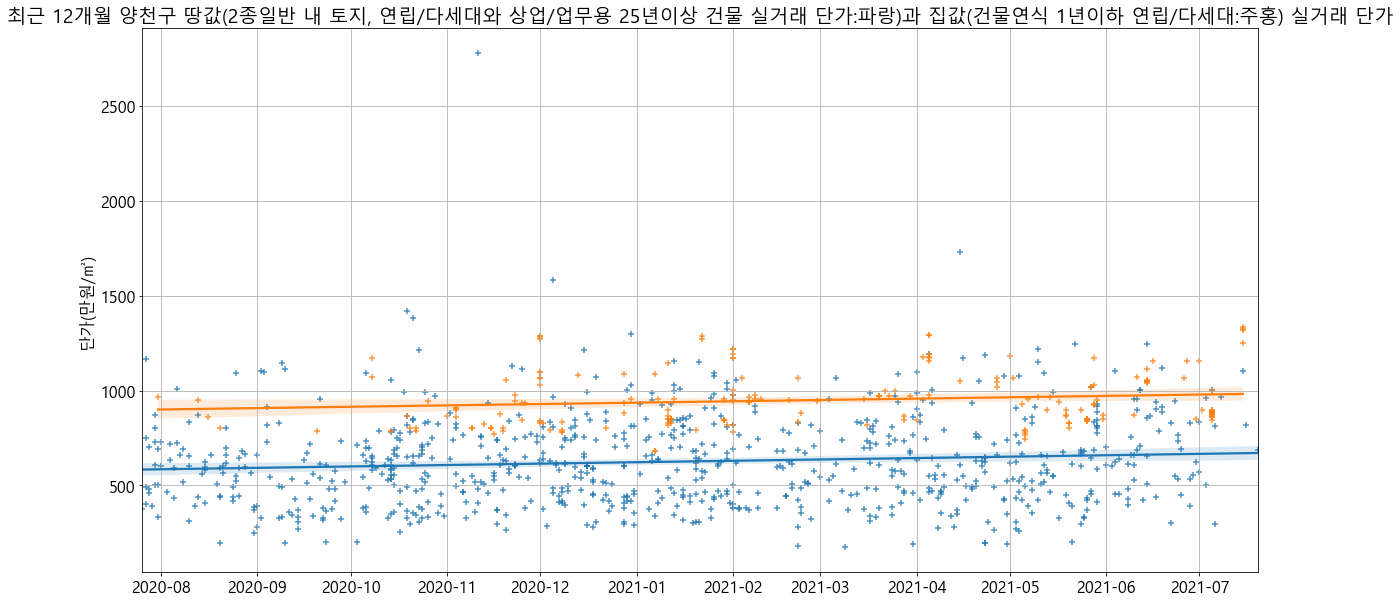

<Figure size 432x288 with 0 Axes>

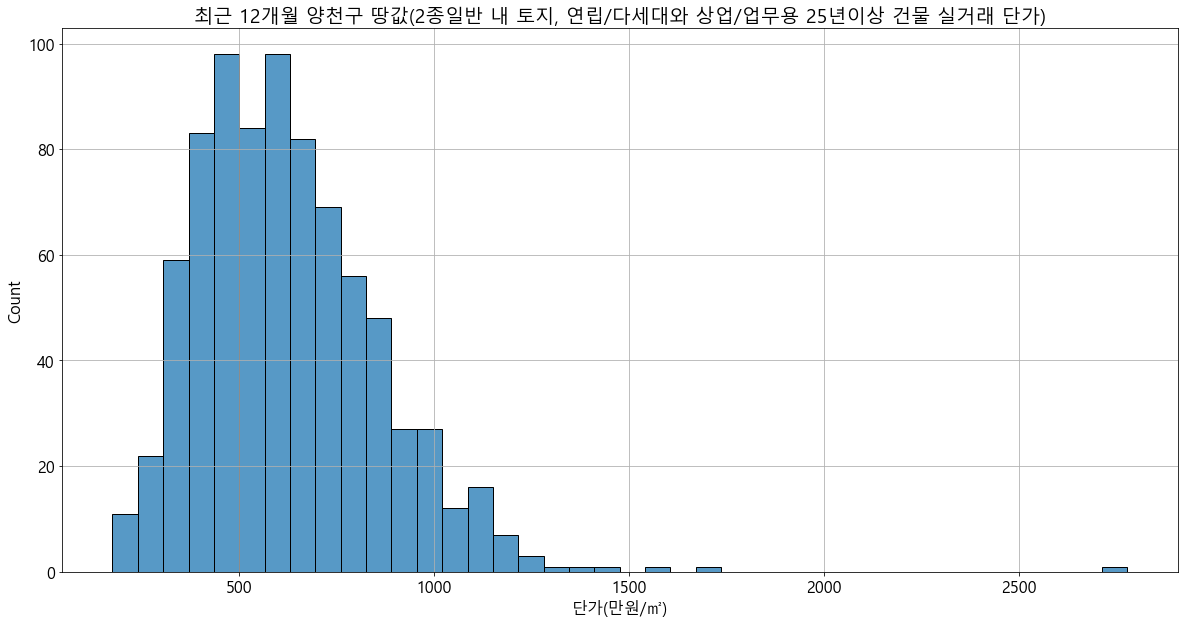

<Figure size 432x288 with 0 Axes>

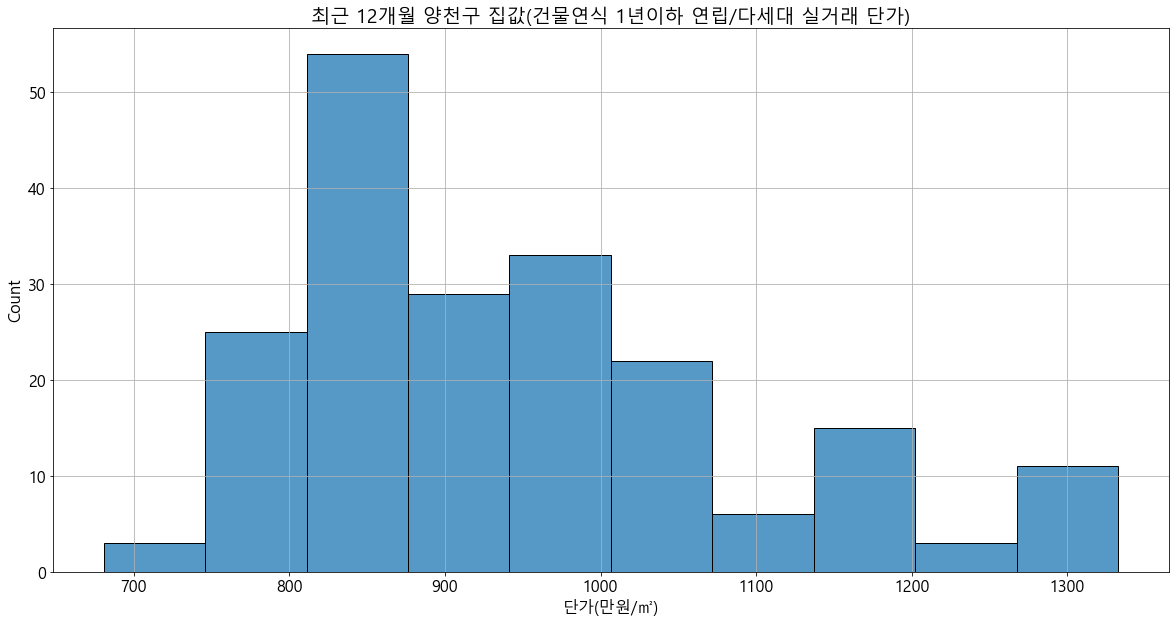

count     201.000000
mean      950.231182
std       143.242307
min       680.751174
25%       846.579129
50%       906.510851
75%      1044.520548
max      1332.658570
Name: 단가(만원/㎡), dtype: float64
count     808.000000
mean      625.393839
std       238.272396
min       175.492611
25%       453.536072
50%       604.997181
75%       760.068553
max      2777.777778
Name: 단가(만원/㎡), dtype: float64
영등포구
제2종일반주거지역    0.550862
준공업지역        0.221425
준주거지역        0.091364
일반상업지역       0.060216
제3종일반주거지역    0.038786
자연녹지지역       0.025503
근린상업지역       0.006066
제1종일반주거지역    0.005778
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

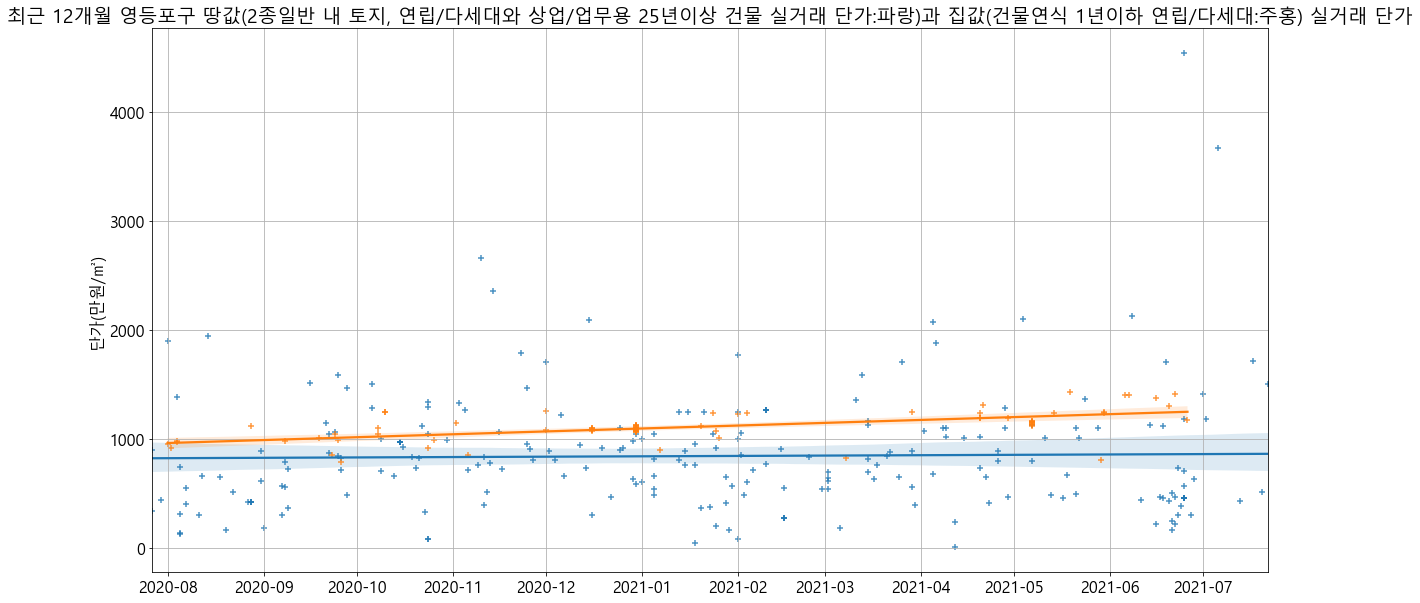

<Figure size 432x288 with 0 Axes>

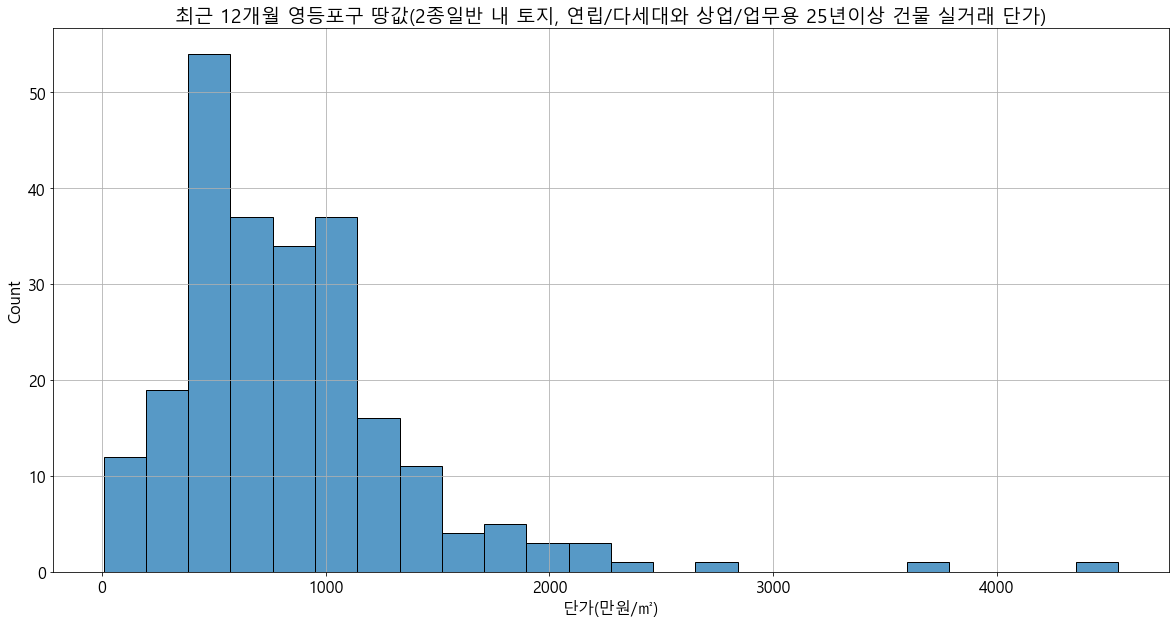

<Figure size 432x288 with 0 Axes>

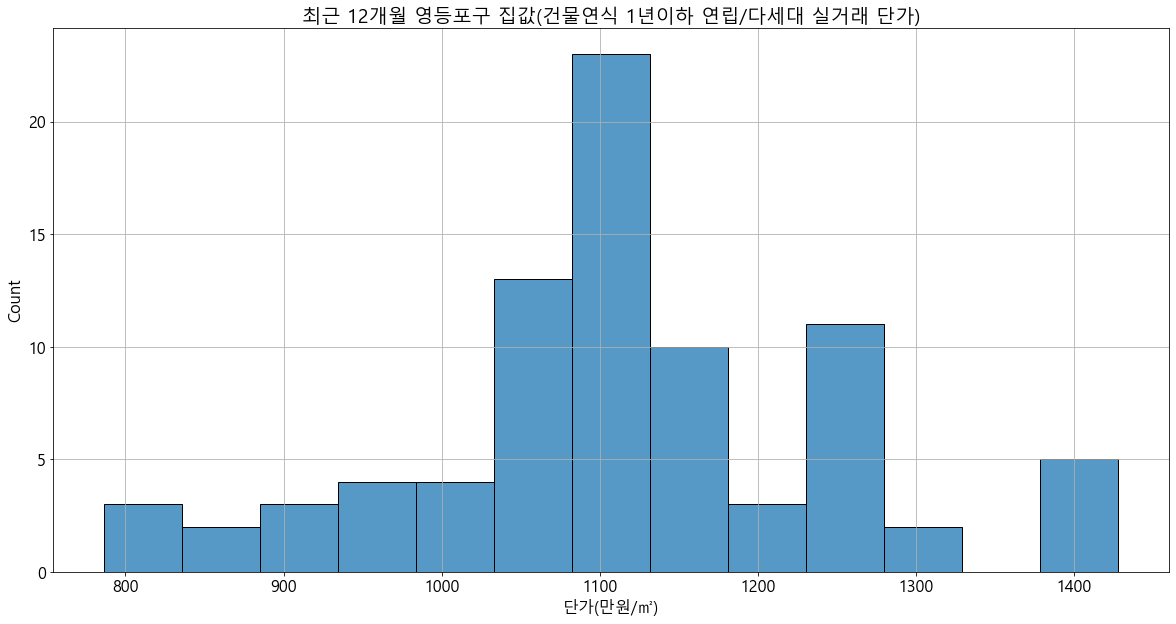

count      83.000000
mean     1113.728251
std       132.186875
min       786.216126
25%      1071.370078
50%      1099.432766
75%      1182.876714
max      1428.094761
Name: 단가(만원/㎡), dtype: float64
count     239.000000
mean      843.479812
std       547.913147
min         7.552870
25%       455.580033
50%       758.620690
75%      1057.404125
max      4541.718044
Name: 단가(만원/㎡), dtype: float64
용산구
제2종일반주거지역    0.476538
제1종일반주거지역    0.239756
제3종일반주거지역    0.105674
일반상업지역       0.098337
준주거지역        0.058650
제1종전용주거지역    0.011254
자연녹지지역       0.008577
보전녹지지역       0.001215
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

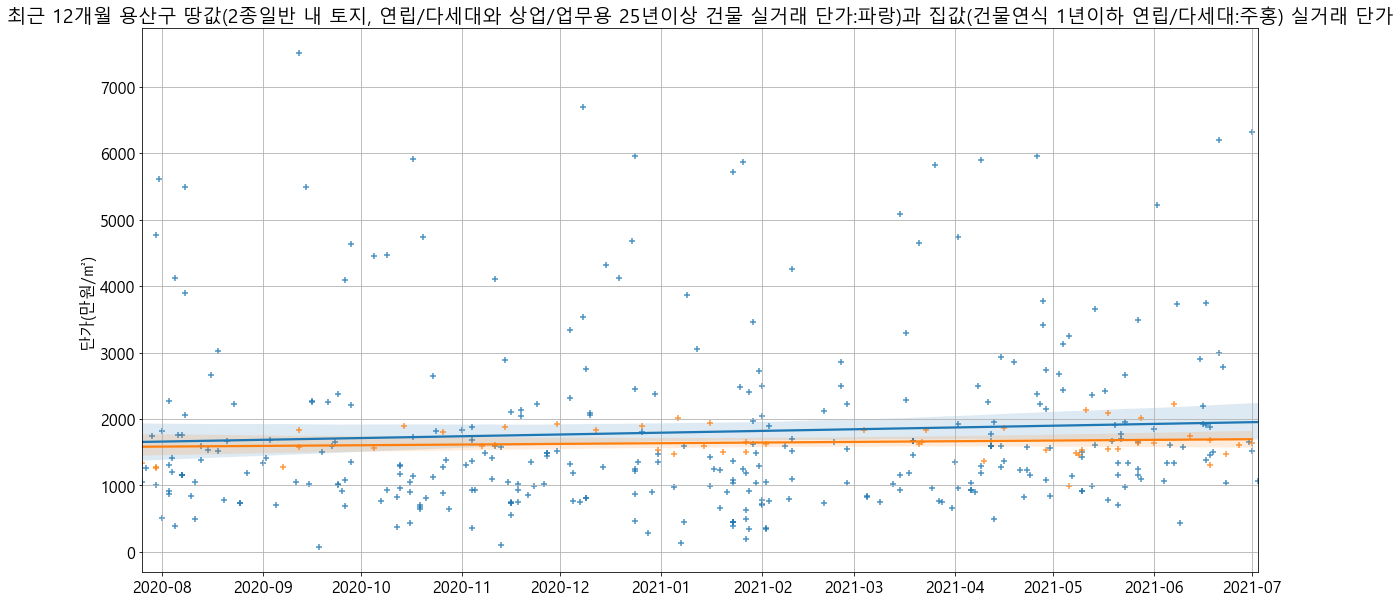

<Figure size 432x288 with 0 Axes>

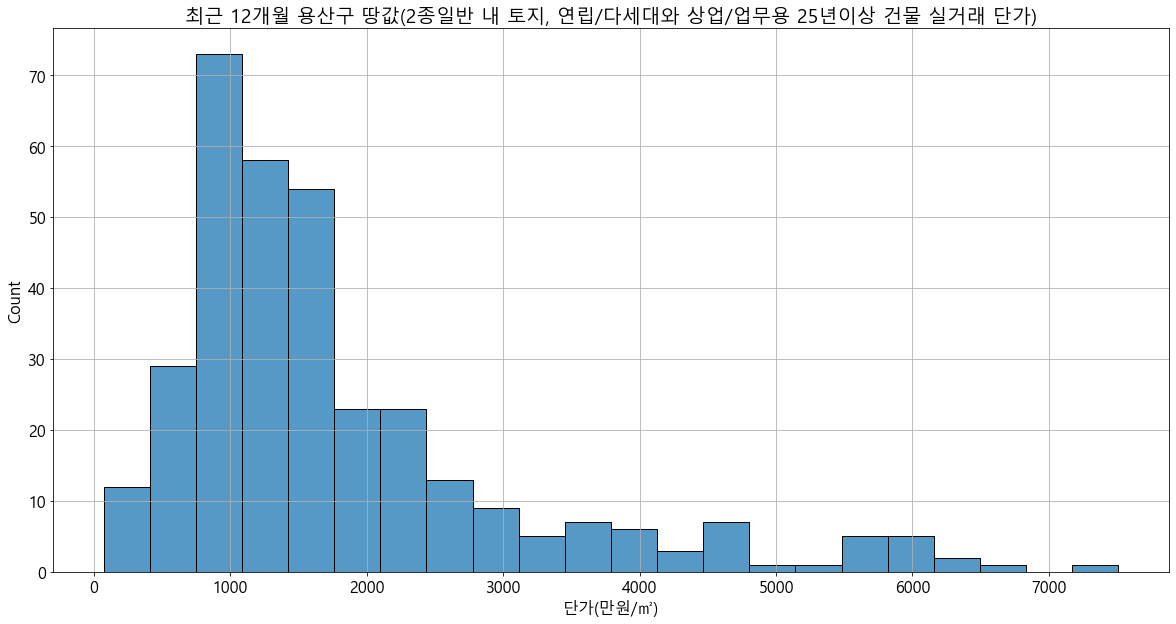

<Figure size 432x288 with 0 Axes>

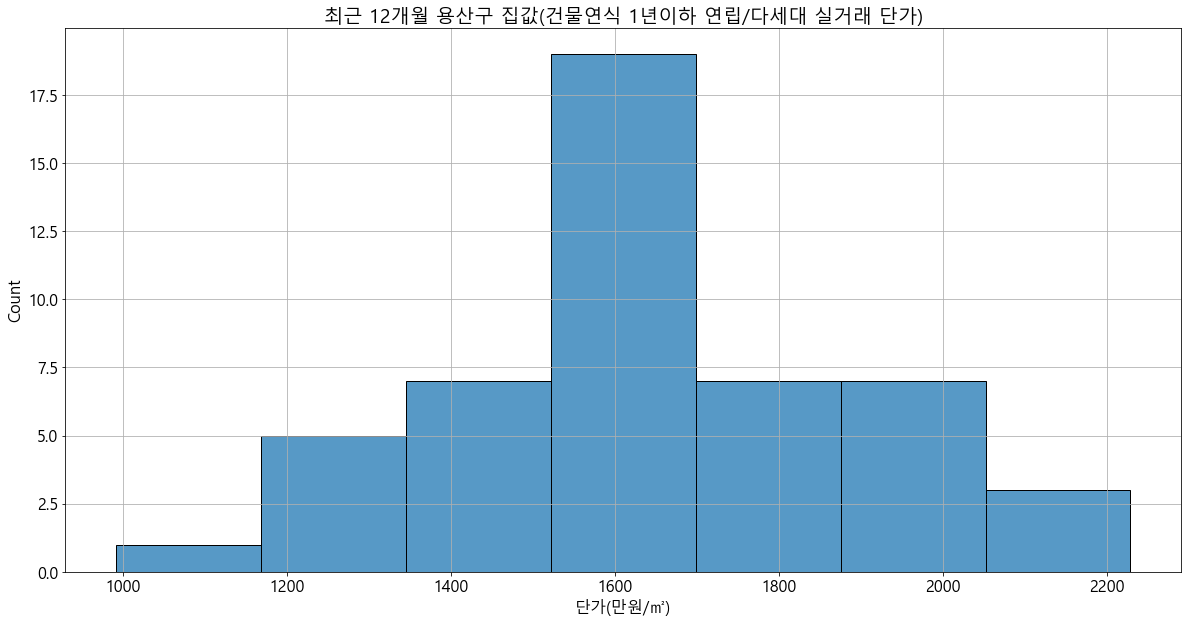

count      49.000000
mean     1650.302015
std       248.934376
min       991.796665
25%      1497.826814
50%      1617.231638
75%      1838.309292
max      2228.412256
Name: 단가(만원/㎡), dtype: float64
count     338.000000
mean     1802.968620
std      1323.786515
min        72.093023
25%       959.103761
50%      1393.780632
75%      2183.759271
max      7508.532423
Name: 단가(만원/㎡), dtype: float64
은평구
제2종일반주거지역    0.601820
제3종일반주거지역    0.141751
제1종일반주거지역    0.096667
준주거지역        0.063859
개발제한구역       0.053247
일반상업지역       0.025391
근린상업지역       0.009579
제1종전용주거지역    0.006118
자연녹지지역       0.001147
제2종전용주거지역    0.000421
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

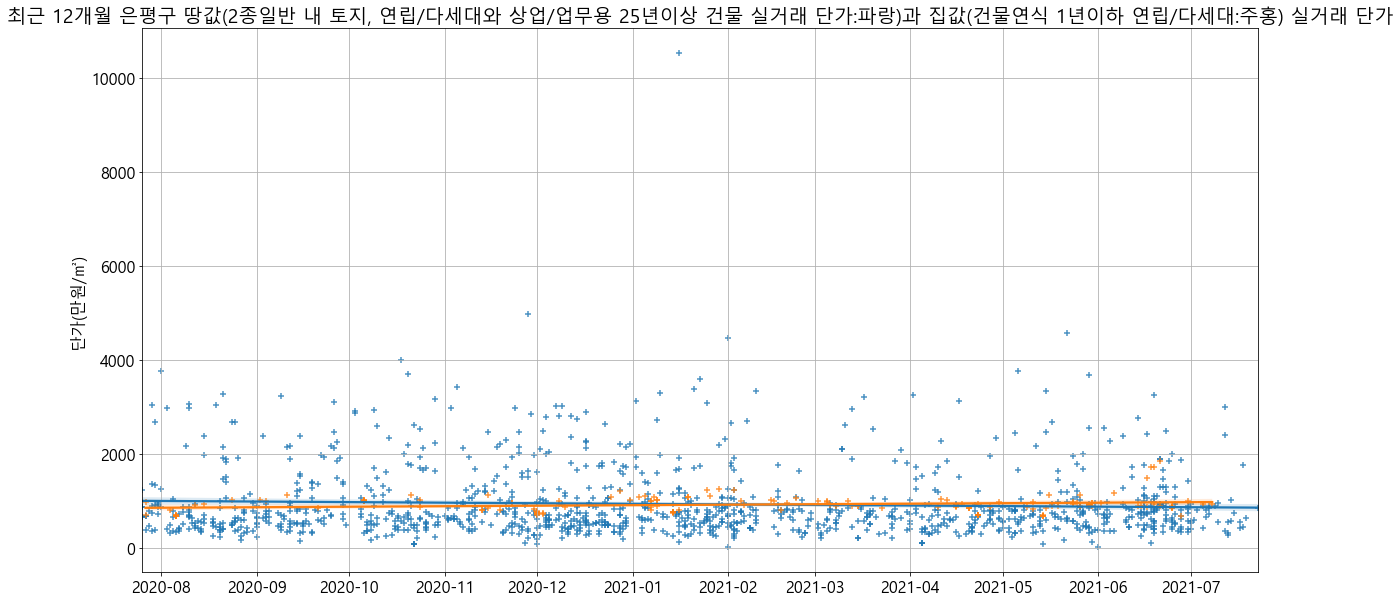

<Figure size 432x288 with 0 Axes>

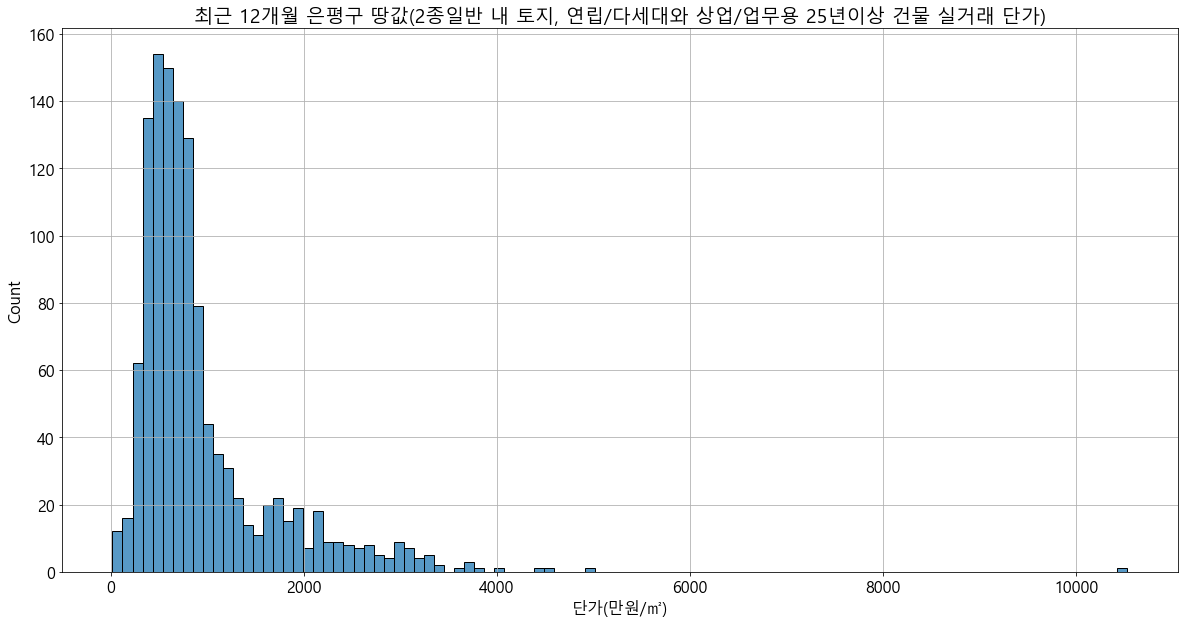

<Figure size 432x288 with 0 Axes>

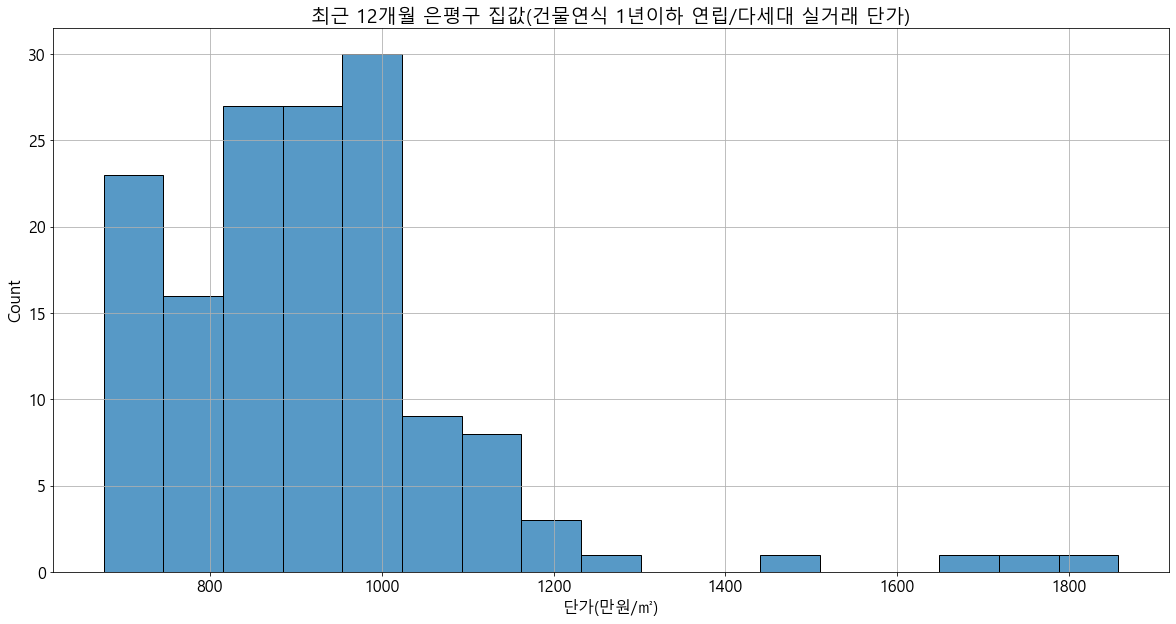

count     148.000000
mean      922.890015
std       186.386952
min       676.328502
25%       812.928022
50%       900.900901
75%      1001.708100
max      1857.142857
Name: 단가(만원/㎡), dtype: float64
count     1222.000000
mean       930.445344
std        751.515289
min         16.666667
25%        485.853703
50%        700.188388
75%       1045.521499
max      10526.315789
Name: 단가(만원/㎡), dtype: float64
종로구
제2종일반주거지역    0.324589
일반상업지역       0.270031
제1종일반주거지역    0.230027
제3종일반주거지역    0.061698
제1종전용주거지역    0.053756
개발제한구역       0.030379
준주거지역        0.020912
자연녹지지역       0.008607
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

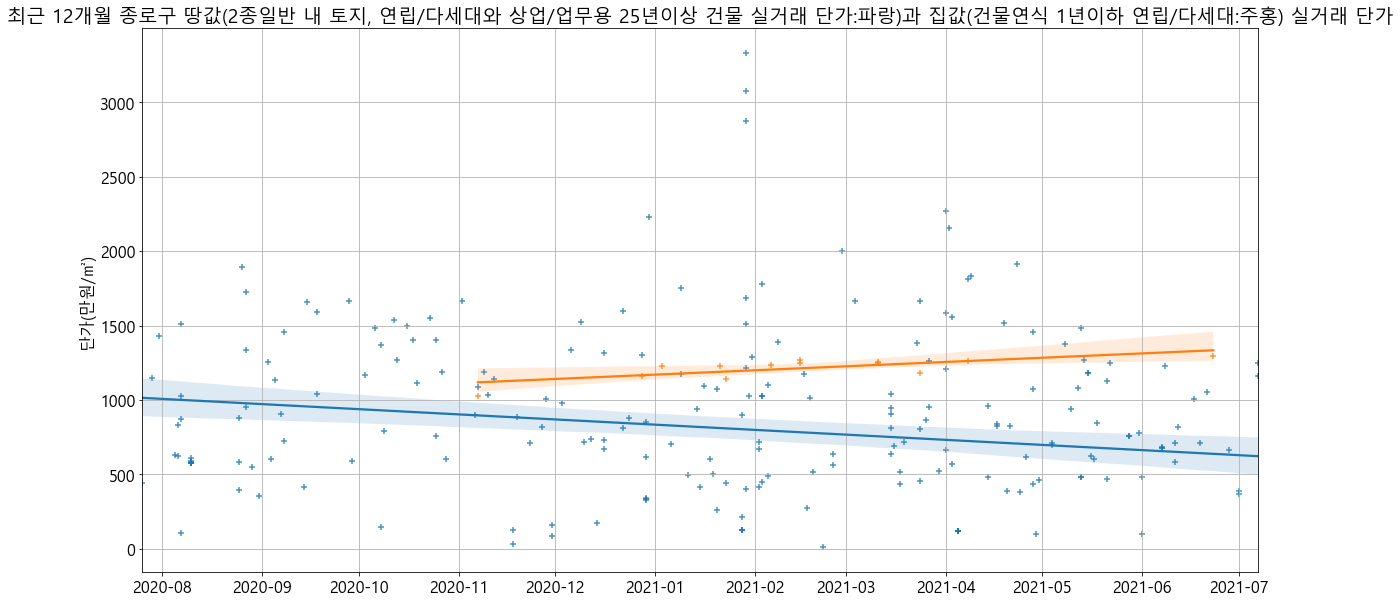

<Figure size 432x288 with 0 Axes>

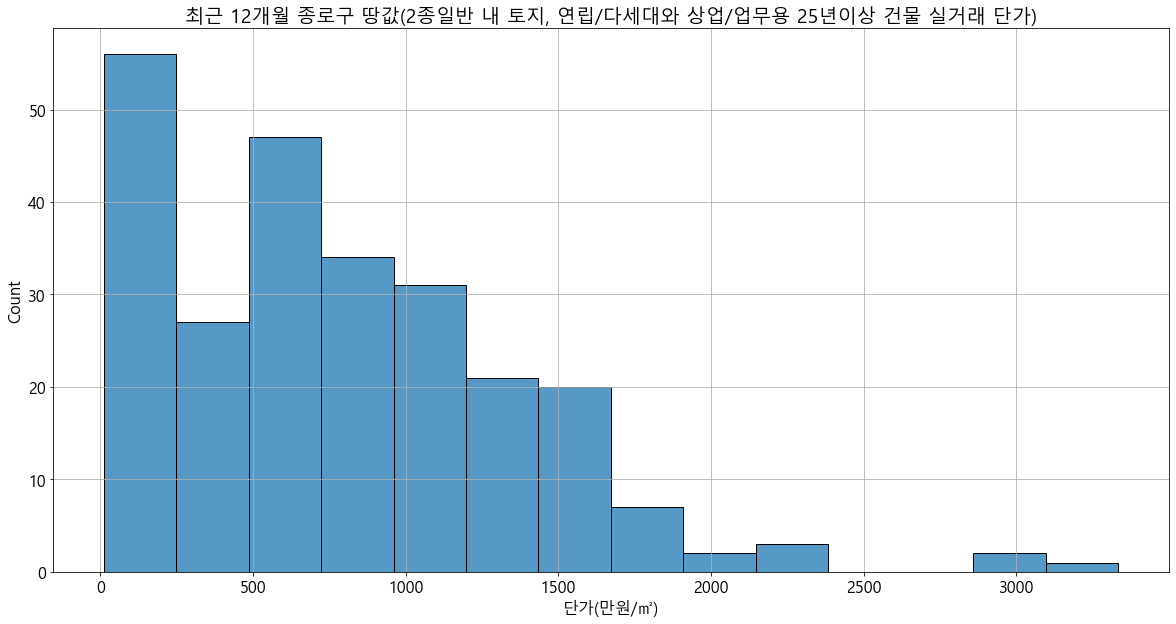

<Figure size 432x288 with 0 Axes>

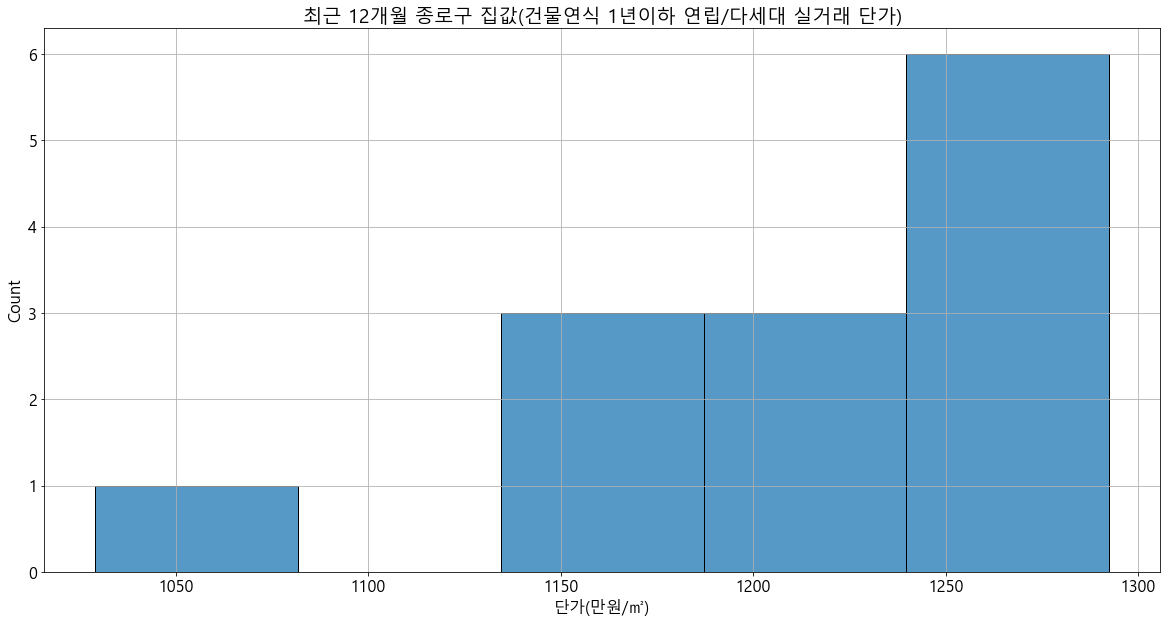

count      13.000000
mean     1214.086343
std        71.244957
min      1028.950122
25%      1180.509042
50%      1235.392321
75%      1257.627119
max      1292.517007
Name: 단가(만원/㎡), dtype: float64
count     251.000000
mean      799.115886
std       578.321955
min        10.781671
25%       375.284968
50%       710.479574
75%      1162.469367
max      3333.333333
Name: 단가(만원/㎡), dtype: float64
중구
일반상업지역       0.462572
제2종일반주거지역    0.294176
제3종일반주거지역    0.089881
제1종일반주거지역    0.088600
준주거지역        0.035430
중심상업지역       0.029342
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

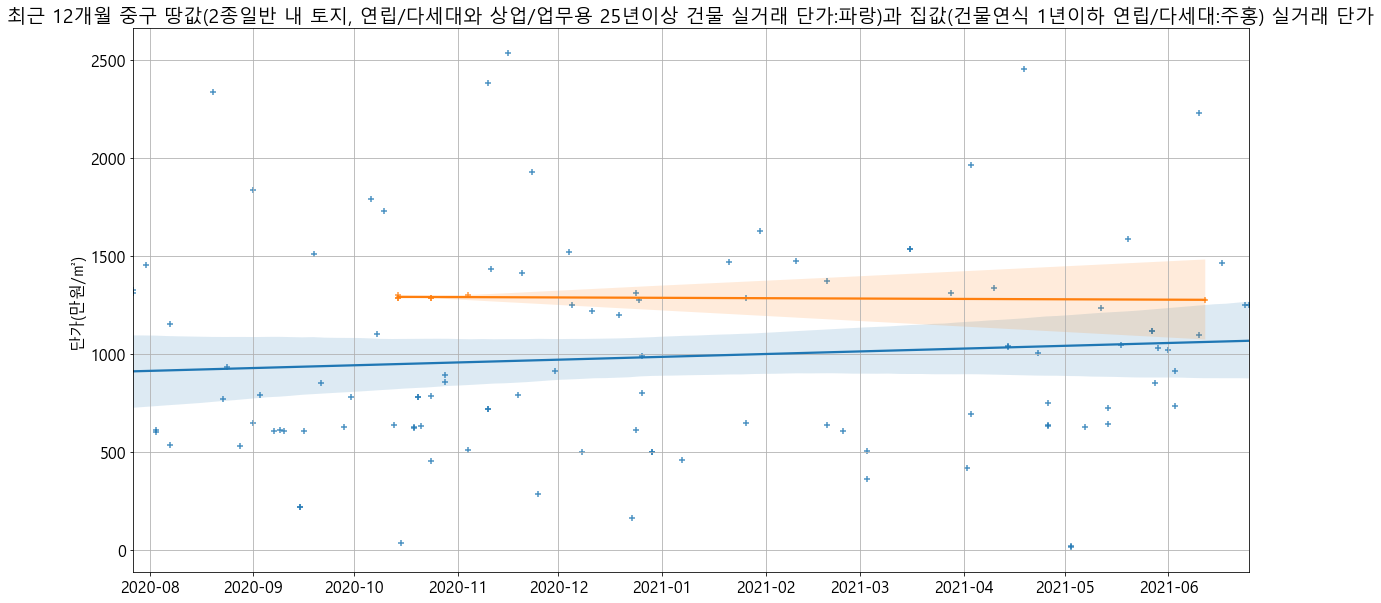

<Figure size 432x288 with 0 Axes>

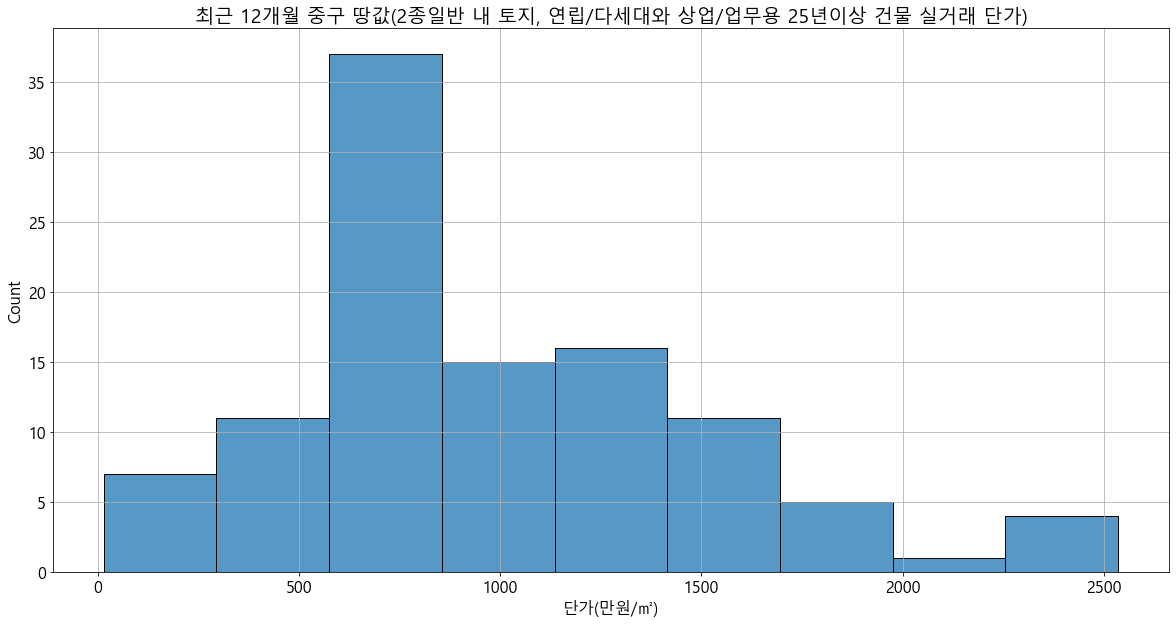

<Figure size 432x288 with 0 Axes>

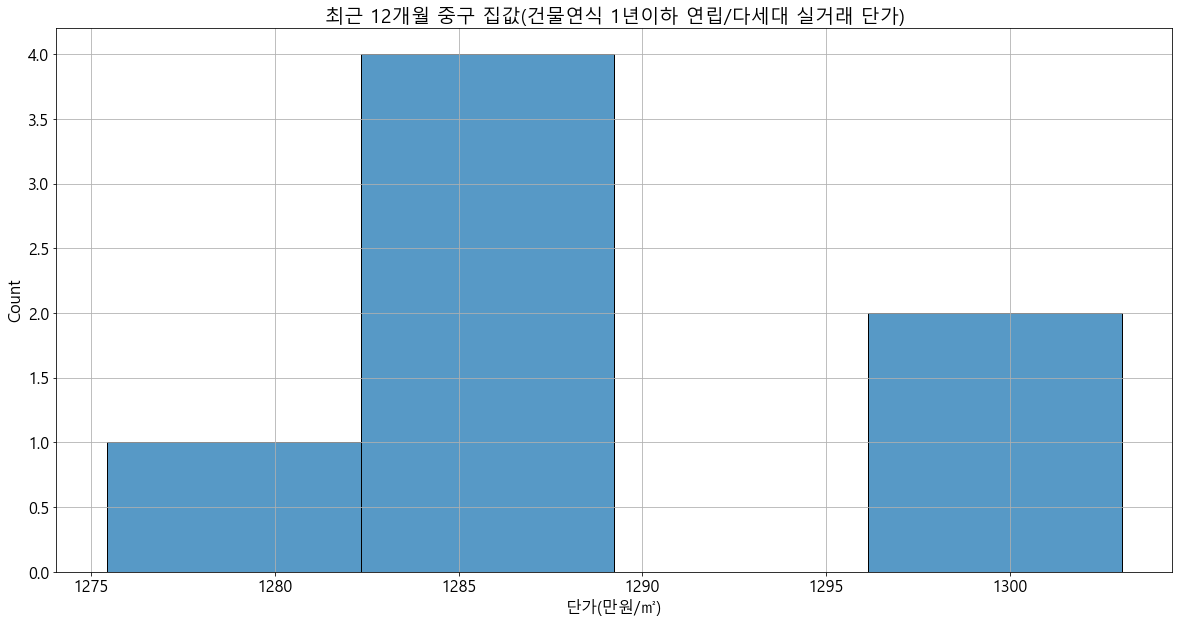

count       7.000000
mean     1288.569253
std        10.227012
min      1275.440977
25%      1283.761254
50%      1285.475793
75%      1294.252532
max      1303.040428
Name: 단가(만원/㎡), dtype: float64
count     107.000000
mean      985.019227
std       528.995213
min        14.285714
25%       625.054532
50%       852.272727
75%      1310.430712
max      2535.787321
Name: 단가(만원/㎡), dtype: float64
중랑구
제2종일반주거지역    0.615623
제3종일반주거지역    0.185899
준주거지역        0.058450
제1종일반주거지역    0.047925
개발제한구역       0.042507
자연녹지지역       0.027805
일반상업지역       0.011814
근린상업지역       0.009976
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

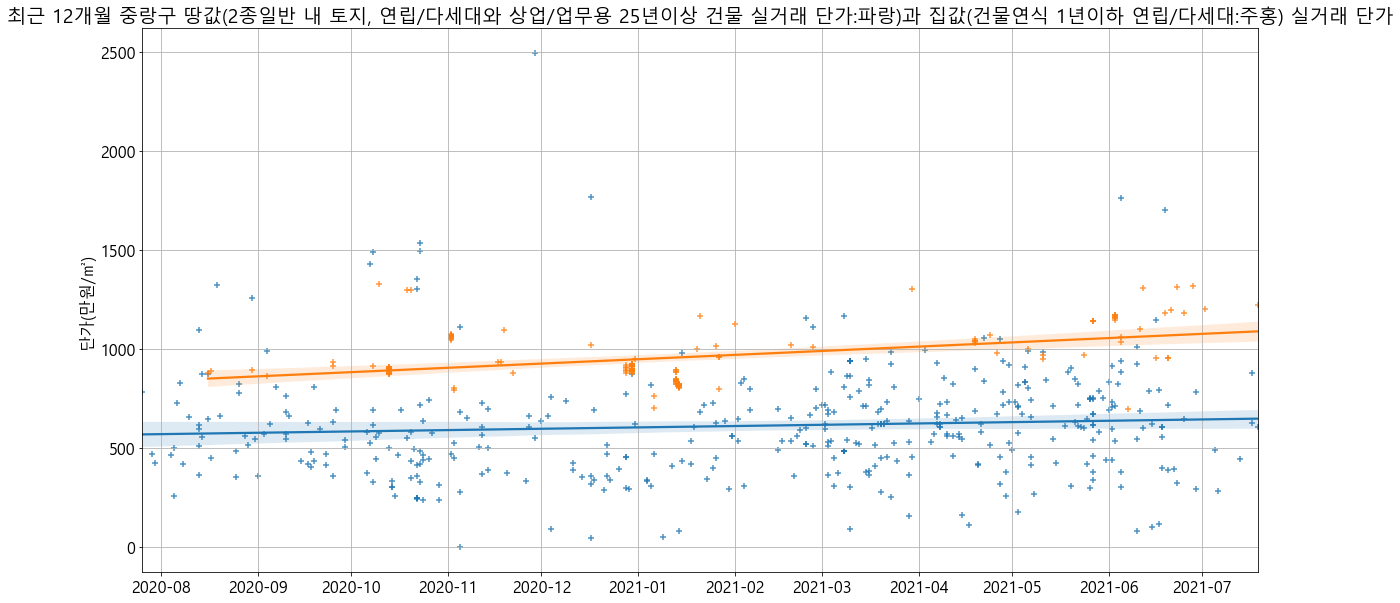

<Figure size 432x288 with 0 Axes>

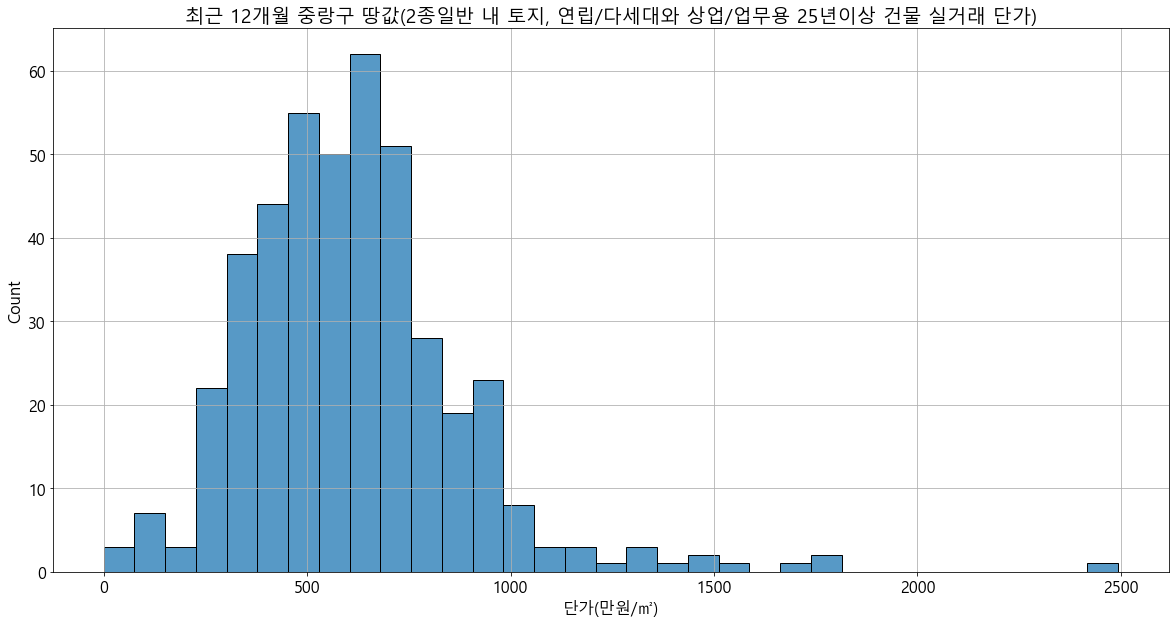

<Figure size 432x288 with 0 Axes>

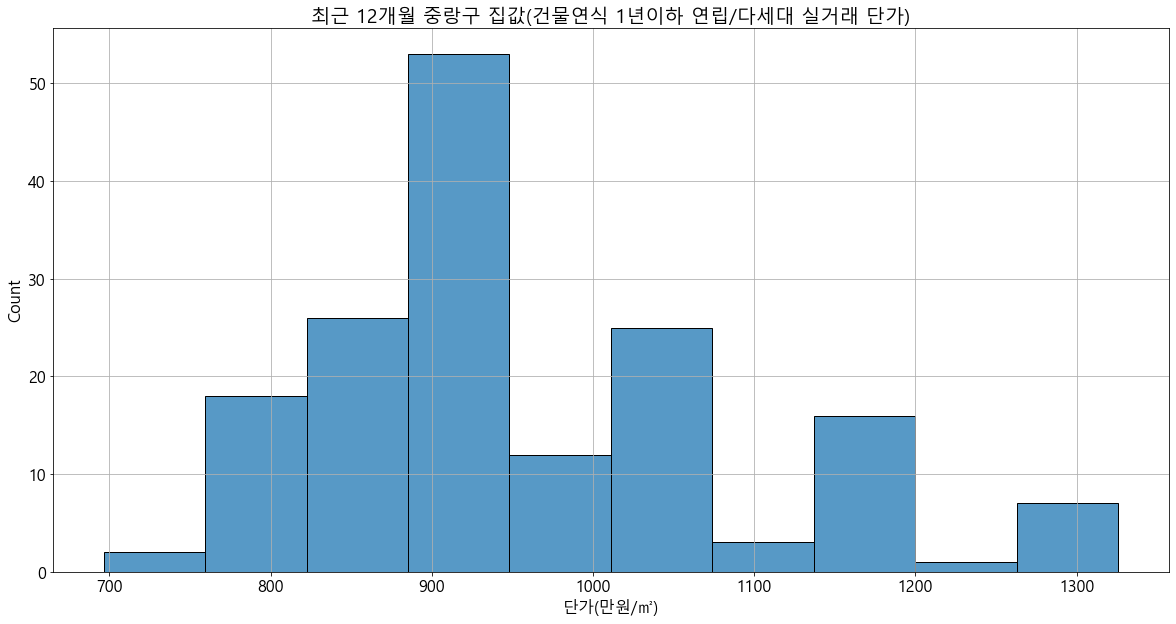

count     163.000000
mean      960.078278
std       133.715358
min       696.428571
25%       880.093520
50%       913.654618
75%      1054.826118
max      1325.850579
Name: 단가(만원/㎡), dtype: float64
count     431.000000
mean      612.090853
std       272.749910
min         0.025000
25%       441.709030
50%       594.444444
75%       732.348178
max      2493.506494
Name: 단가(만원/㎡), dtype: float64
성동구
제2종일반주거지역    0.481518
제3종일반주거지역    0.282662
준공업지역        0.107325
제1종일반주거지역    0.041124
자연녹지지역       0.030765
준주거지역        0.027680
일반상업지역       0.026180
근린상업지역       0.002151
유통상업지역       0.000594
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

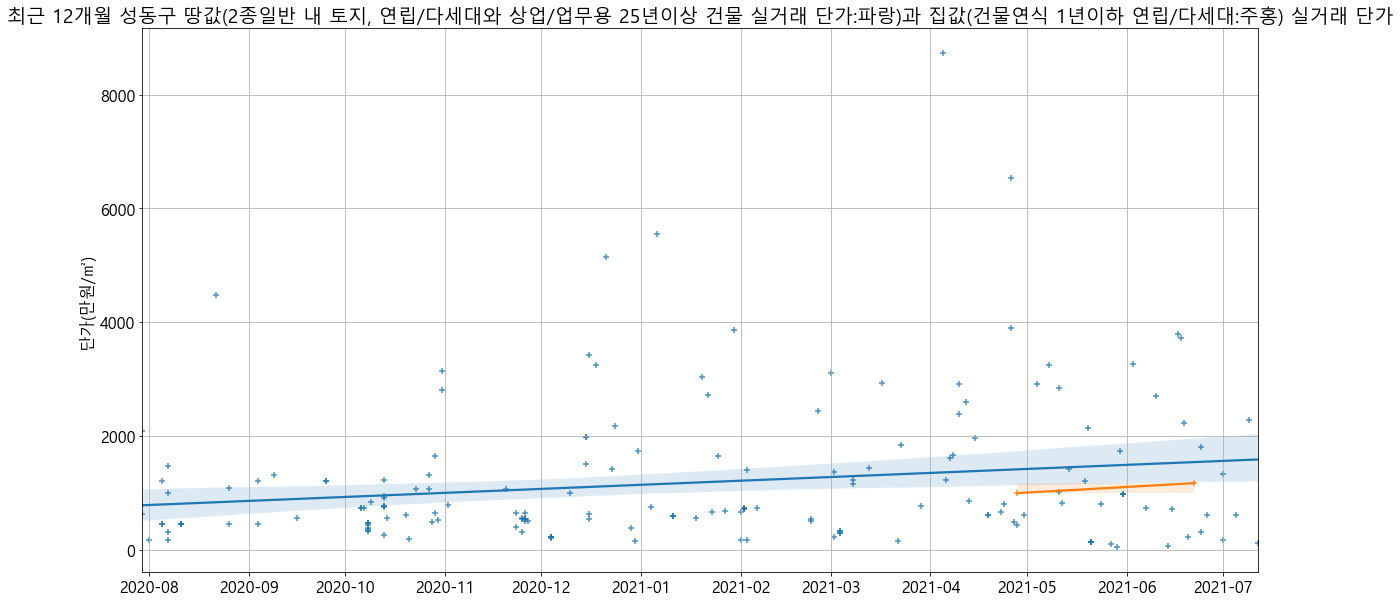

<Figure size 432x288 with 0 Axes>

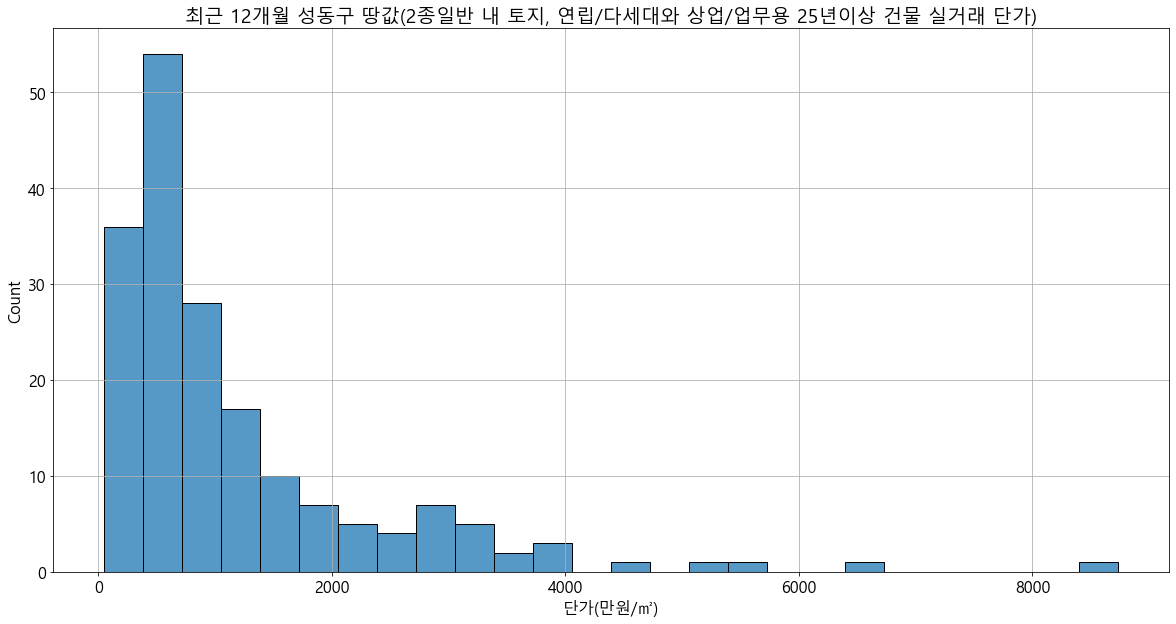

<Figure size 432x288 with 0 Axes>

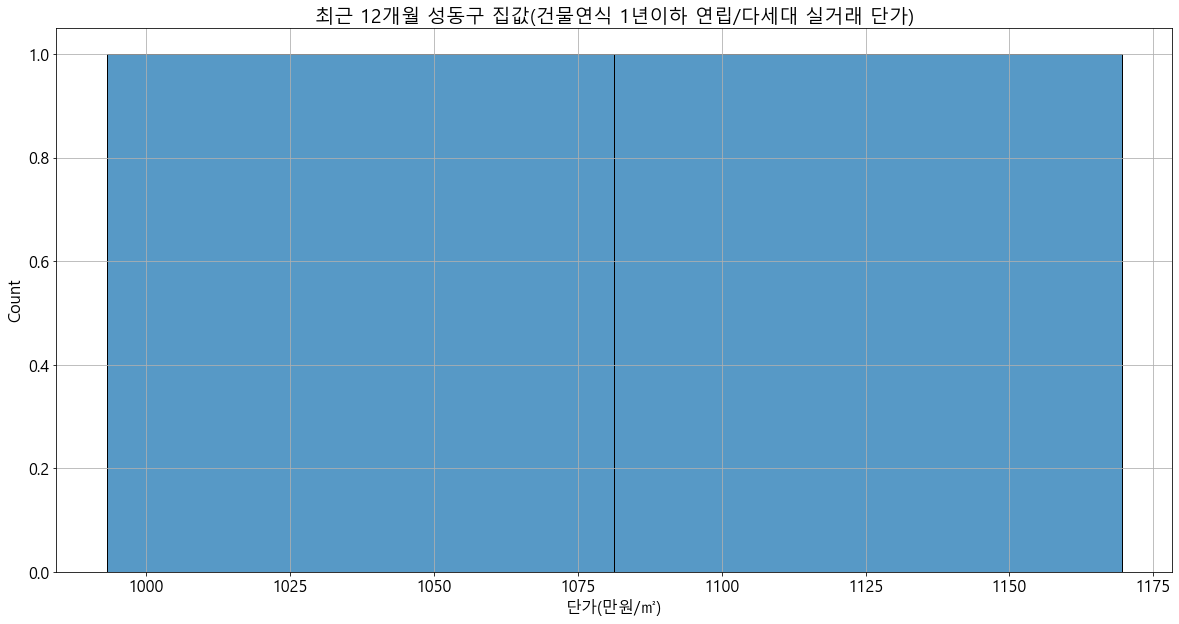

count       2.000000
mean     1081.364396
std       124.687133
min       993.197279
25%      1037.280838
50%      1081.364396
75%      1125.447955
max      1169.531513
Name: 단가(만원/㎡), dtype: float64
count     183.000000
mean     1175.105383
std      1245.536145
min        44.835329
25%       454.545455
50%       720.000000
75%      1419.966356
max      8734.522942
Name: 단가(만원/㎡), dtype: float64


<Figure size 432x288 with 0 Axes>

In [27]:
stats_df = pd.DataFrame({'구':[], '땅값_중간값':[], '땅값_평균':[], '집값_중간값':[], '집값_평균':[]})

target_purpose = '2종일반'
font = {'size': 16}
matplotlib.rc('font', **font)
count = 0
for gu in yunrip_merge_df['구'].unique():
    print(gu)
    
    last_addr_df = last_df[
        (last_df['구'] == gu)
    ]
    
    val_counts = last_addr_df['용도지역명1'].value_counts(normalize=True)
    print(val_counts)
    
    # 집값
    yunrip_addr_df = yunrip_merge_df[
        (yunrip_merge_df['구'] == gu)
    ]
    
    # 땅값
    common_addr_df = common_df[
        (common_df['구'] == gu)
        &(common_df['용도지역'].str.contains(target_purpose))
    ]
    
    val_counts_df = pd.DataFrame({'{}'.format(gu):[idx for idx in val_counts.index],
                                  '비율':[v for v in val_counts.values]
                                 })
    
    val_counts_df.to_excel('./국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_용도지역_비율.xlsx'.format(target_months, gu), index=False)
    
    f, ax = plt.subplots(figsize=(20,10))
    plt.title('최근 {}개월 {} 땅값(2종일반 내 토지, 연립/다세대와 상업/업무용 25년이상 건물 실거래 단가:파랑)과 집값(건물연식 1년이하 연립/다세대:주홍) 실거래 단가'.format(target_months, gu))
    plt.grid(True)
    ax.xaxis.update_units(common_addr_df['계약날짜'])
    sns.regplot(x=ax.xaxis.convert_units(common_addr_df['계약날짜']), y=common_addr_df['단가(만원/㎡)'], order=1,# ci=None,
                marker='+'
               )
    ax.xaxis.update_units(yunrip_addr_df['계약날짜'])
    sns.regplot(x=ax.xaxis.convert_units(yunrip_addr_df['계약날짜']), y=yunrip_addr_df['단가(만원/㎡)'], order=1,# ci=None,
                marker='+'
               )
    #plt.ylim([0, 1500])
    plt.savefig('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_산포도.png'.format(target_months, gu))
    
    plt.show()
    plt.clf()
    
    f, ax = plt.subplots(figsize=(20,10))
    plt.title('최근 {}개월 {} 땅값(2종일반 내 토지, 연립/다세대와 상업/업무용 25년이상 건물 실거래 단가)'.format(target_months, gu))
    plt.grid(True)
    sns.histplot(common_addr_df['단가(만원/㎡)'])
    
    plt.savefig('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_땅값_분포도.png'.format(target_months, gu))
    
    plt.show()
    plt.clf()
    
    f, ax = plt.subplots(figsize=(20,10))
    plt.title('최근 {}개월 {} 집값(건물연식 1년이하 연립/다세대 실거래 단가)'.format(target_months, gu))
    plt.grid(True)
    sns.histplot(yunrip_addr_df['단가(만원/㎡)'])
    
    plt.savefig('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_집값_분포도.png'.format(target_months, gu))
    
    plt.show()
    plt.clf()
    
    
    
    house_price_description = yunrip_addr_df['단가(만원/㎡)'].describe()
    land_price_description = common_addr_df['단가(만원/㎡)'].describe()
    
    print(house_price_description)
    print(land_price_description)
    
    house_price_description_df = pd.DataFrame({'{}'.format(gu): [idx for idx in house_price_description.index],
                                               '값': [v for v in house_price_description.values]
                                              })
    land_price_description_df = pd.DataFrame({'{}'.format(gu): [idx for idx in land_price_description.index],
                                               '값': [v for v in land_price_description.values]
                                              })
    
    house_price_description_df.to_excel('./국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_집값_통계수치들.xlsx'.format(target_months, gu), index=False)
    land_price_description_df.to_excel('./국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_땅값_통계수치들.xlsx'.format(target_months, gu), index=False)
    
    stats_df.loc[count, '구'] = gu
    stats_df.loc[count, '땅값_중간값'] = land_price_description['50%']
    stats_df.loc[count, '땅값_평균'] = land_price_description['mean']
    stats_df.loc[count, '집값_중간값'] = house_price_description['50%']
    stats_df.loc[count, '집값_평균'] = house_price_description['mean']
    
    count += 1

In [28]:
stats_df.head()

,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균
0,강남구,1553.398058,1670.416273,1783.701010,1740.866742
1,강동구,811.462239,812.725099,949.748744,1005.416123
2,강북구,476.906146,544.779342,784.117451,766.784012
3,강서구,585.735758,575.080193,936.425305,957.356929
4,관악구,689.013035,763.578464,1044.328476,1019.776647


In [29]:
stats_df['중간값_차이'] = stats_df['집값_중간값'] - stats_df['땅값_중간값']
stats_df['평균_차이'] = stats_df['집값_평균'] - stats_df['땅값_평균']

In [30]:
print(stats_df.shape)
stats_df.head()

(25, 7)


,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균,중간값_차이,평균_차이
0,강남구,1553.398058,1670.416273,1783.701010,1740.866742,230.302952,70.450469
1,강동구,811.462239,812.725099,949.748744,1005.416123,138.286505,192.691024
2,강북구,476.906146,544.779342,784.117451,766.784012,307.211305,222.004670
3,강서구,585.735758,575.080193,936.425305,957.356929,350.689546,382.276736
4,관악구,689.013035,763.578464,1044.328476,1019.776647,355.315441,256.198183


In [31]:
stats_ordered_by_median_df = stats_df.sort_values(['중간값_차이'], ascending=False)
print(stats_ordered_by_median_df.shape)
stats_ordered_by_median_df.head()

(25, 7)


,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균,중간값_차이,평균_차이
21,종로구,710.479574,799.115886,1235.392321,1214.086343,524.912747,414.970456
22,중구,852.272727,985.019227,1285.475793,1288.569253,433.203066,303.550026
24,성동구,720.000000,1175.105383,1081.364396,1081.364396,361.364396,-93.740987
4,관악구,689.013035,763.578464,1044.328476,1019.776647,355.315441,256.198183
3,강서구,585.735758,575.080193,936.425305,957.356929,350.689546,382.276736


In [32]:
stats_ordered_by_mean_df = stats_df.sort_values(['평균_차이'], ascending=False)
print(stats_ordered_by_mean_df.shape)
stats_ordered_by_mean_df.head()

(25, 7)


,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균,중간값_차이,평균_차이
21,종로구,710.479574,799.115886,1235.392321,1214.086343,524.912747,414.970456
3,강서구,585.735758,575.080193,936.425305,957.356929,350.689546,382.276736
23,중랑구,594.444444,612.090853,913.654618,960.078278,319.210174,347.987425
17,양천구,604.997181,625.393839,906.510851,950.231182,301.513671,324.837343
7,금천구,472.290405,492.673677,796.460586,814.984525,324.170180,322.310847


In [33]:
stats_ordered_by_median_df.to_excel('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/취합_통계자료/땅집값_비교통계_중간값순정렬.xlsx'.format(target_months), index=False)

In [34]:
stats_ordered_by_mean_df.to_excel('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/취합_통계자료/땅집값_비교통계_평균순정렬.xlsx'.format(target_months), index=False)